In [1]:
import logging
import warnings
from typing import Optional, Any, Literal

import numpy as np
import matplotlib.pyplot as plt

from gwpy.types import Series
from gwpy.frequencyseries import FrequencySeries
import astropy.units as u
import lalsimulation.gwsignal.core.waveform as wfm

from gw_signal_tools.inner_product import inner_product, inner_product_computation, norm
from gw_signal_tools.waveform_utils import restrict_f_range

import warnings
warnings.filterwarnings('ignore', '.*This code is currently UNREVIEWED, use with caution!.*')

/home/user/miniconda3/envs/gw_signal_tools/lib/python3.11/site-packages/gwpy/time/__init__.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(True)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  from lal import LIGOTimeGPS


The pyseobnr package has failed to load, you will not be able to employ SEOBNRv5 approximants.


In [2]:
from gw_signal_tools import PLOT_STYLE_SHEET
plt.style.use(PLOT_STYLE_SHEET)

## Code Tests

In [3]:
isinstance('test', str)

True

In [4]:
x_vals = np.arange(5)

y_vals = 2.0 * np.arange(5)

out = np.polyfit(x_vals, y_vals, 1, full=True)

In [5]:
print(out)

(array([2.00000000e+00, 1.12769851e-15]), array([3.00161574e-30]), 2, array([1.34777468, 0.42837299]), 1.1102230246251565e-15)


In [6]:
test = [1,2,3]

test.pop(0)

test

[2, 3]

In [7]:
test = np.arange(5)
test[np.logical_not(5 * [False])] = 96

test

array([96, 96, 96, 96, 96])

In [8]:
test[np.logical_not(5 * [True])]

array([], dtype=int64)

In [9]:
np.nanargmin([0.0, np.nan, 1.0, -1.0])

3

In [10]:
# test = np.zeros((2,2))
# # test = u.Quantity(np.zeros((2,2)))

# test[0, 1] = 2.0 * u.s

# test

Hmmm, error, that's awkward... Then we have to find workaround for Fisher matrix to hold values with different values

## Testing Implementation

In [11]:
from gw_signal_tools.fisher_matrix import fisher_val_v3, get_waveform_derivative_1D

In [12]:
# f_min = 10.*u.Hz  # Cutoff frequency
f_min = 20.*u.Hz  # Cutoff frequency
f_max = 1024. * u.Hz  # Cutoff from PSD
# delta_f = 2**-6 * u.Hz  # Actually works much better
delta_f = 2**-8 * u.Hz  # Actually works much better
delta_t = 1.0/4096.0 * u.s
f_ref = 20.*u.Hz  # Frequency where we specify spins
# f_ref = f_min  # Frequency where we specify spins
distance = 1.*u.Mpc
inclination = 0.0*u.rad  # Value taken from posteriors.ipynb, where posterior of inclination is plotted
phiRef = 0.*u.rad
eccentricity = 0.*u.dimensionless_unscaled
longAscNodes = 0.*u.rad
meanPerAno = 0.*u.rad


# Define the approximant
approximant = 'IMRPhenomXPHM'
# approximant = 'SEOBNRv4'

# Initialize the generator
gen = wfm.LALCompactBinaryCoalescenceGenerator(approximant)

wf_center_parameters = {
    'total_mass': 100.*u.solMass,
    # 'mass_ratio': 0.5*u.dimensionless_unscaled,
    'sym_mass_ratio': 0.05*u.dimensionless_unscaled,
    'f22_start' : f_min,
    'f_max' : f_max,
    'deltaT' : delta_t,
    'deltaF' : delta_f,
    'f22_ref': f_ref,
    'phi_ref' : phiRef,
    'distance' : distance,
    'inclination' : inclination,
    'eccentricity' : eccentricity,
    'longAscNodes' : longAscNodes,
    'meanPerAno' : meanPerAno,
    'condition' : 0
    # 'condition' : 1  # Needs to be on for SEOB
}

### Convergence Testing

In [13]:
more_step_sizes = np.reshape(np.outer([1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8], [5, 1]), -1)

/home/user/miniconda3/envs/gw_signal_tools/lib/python3.11/site-packages/lalsimulation/gwsignal/core/utils.py:277: UserWarning: The larger object cannot be determined, assuming m1 >= m2.
  warnings.warn(warn_string)
XLAL Warning - XLALSimInspiralWaveformParamsLookupMass1 (LALSimInspiralWaveformParams.c:490): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupSymMassRatio (LALSimInspiralWaveformParams.c:869): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralGetMassRatioFromSymMassRatio (LALSimInspiralWaveformParams.c:427): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWavefo

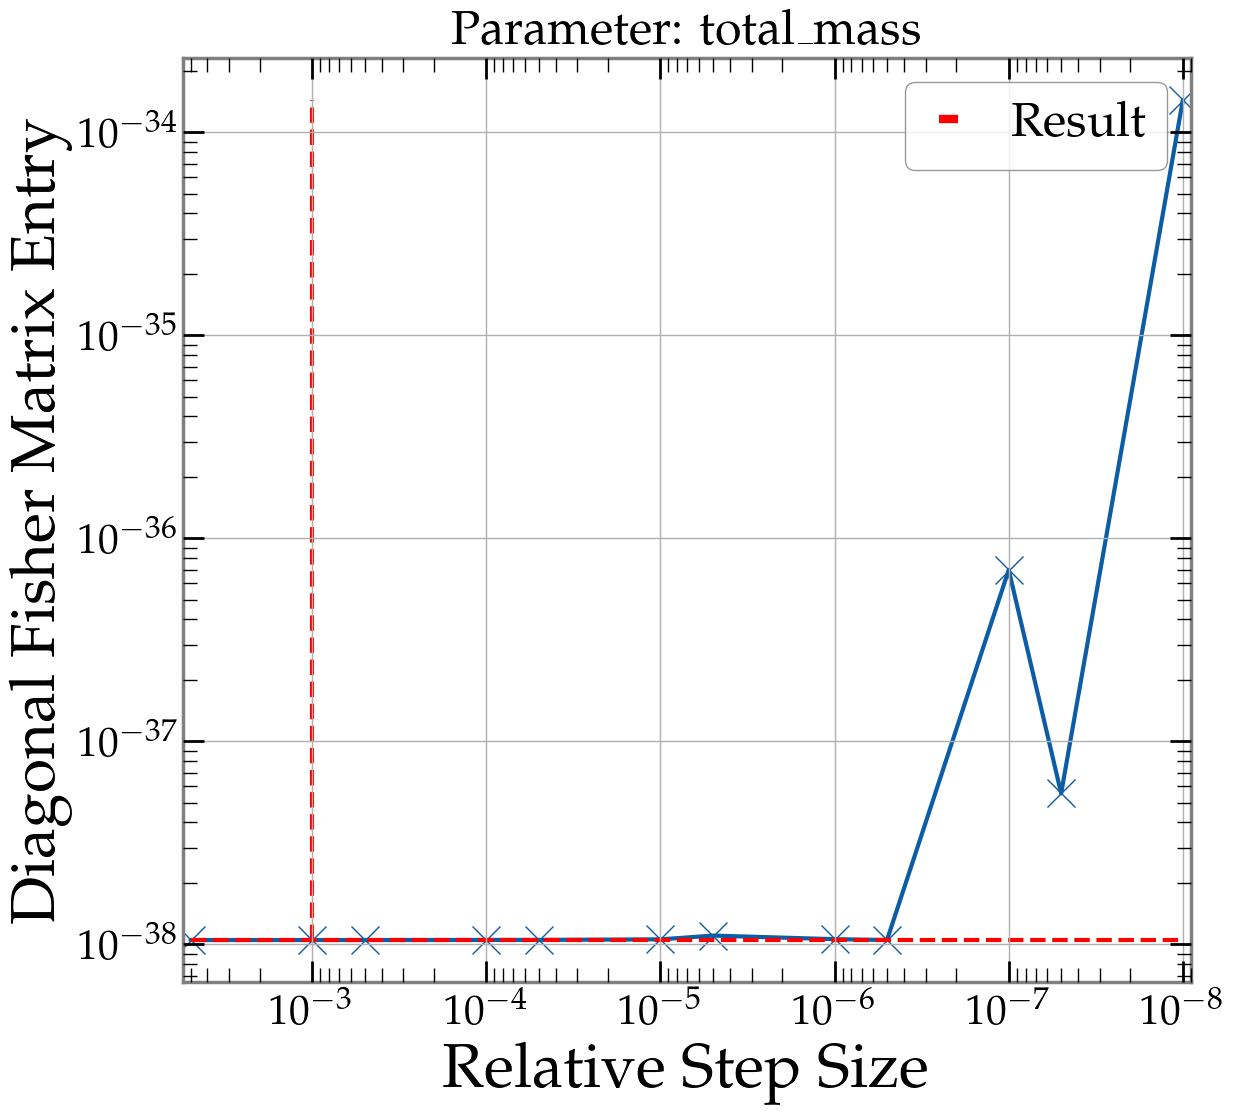

In [14]:
fisher_test_rel_crit = fisher_val_v3(
    wf_center_parameters,
    'total_mass',
    gen,
    step_sizes=more_step_sizes,
    convergence_plot=True
)


# fisher_test_rel_crit_2 = fisher_val_v3(
#     wf_center_parameters,
#     'total_mass',
#     gen,
#     step_sizes=more_step_sizes,
#     convergence_threshold=0.0,  # Cannot be reached, want to see convergence
#     convergence_plot=True
# )

# We see convergence anyway for 'stem' check

/home/user/miniconda3/envs/gw_signal_tools/lib/python3.11/site-packages/lalsimulation/gwsignal/core/utils.py:277: UserWarning: The larger object cannot be determined, assuming m1 >= m2.
  warnings.warn(warn_string)
XLAL Warning - XLALSimInspiralWaveformParamsLookupMass1 (LALSimInspiralWaveformParams.c:490): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupSymMassRatio (LALSimInspiralWaveformParams.c:869): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralGetMassRatioFromSymMassRatio (LALSimInspiralWaveformParams.c:427): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWavefo

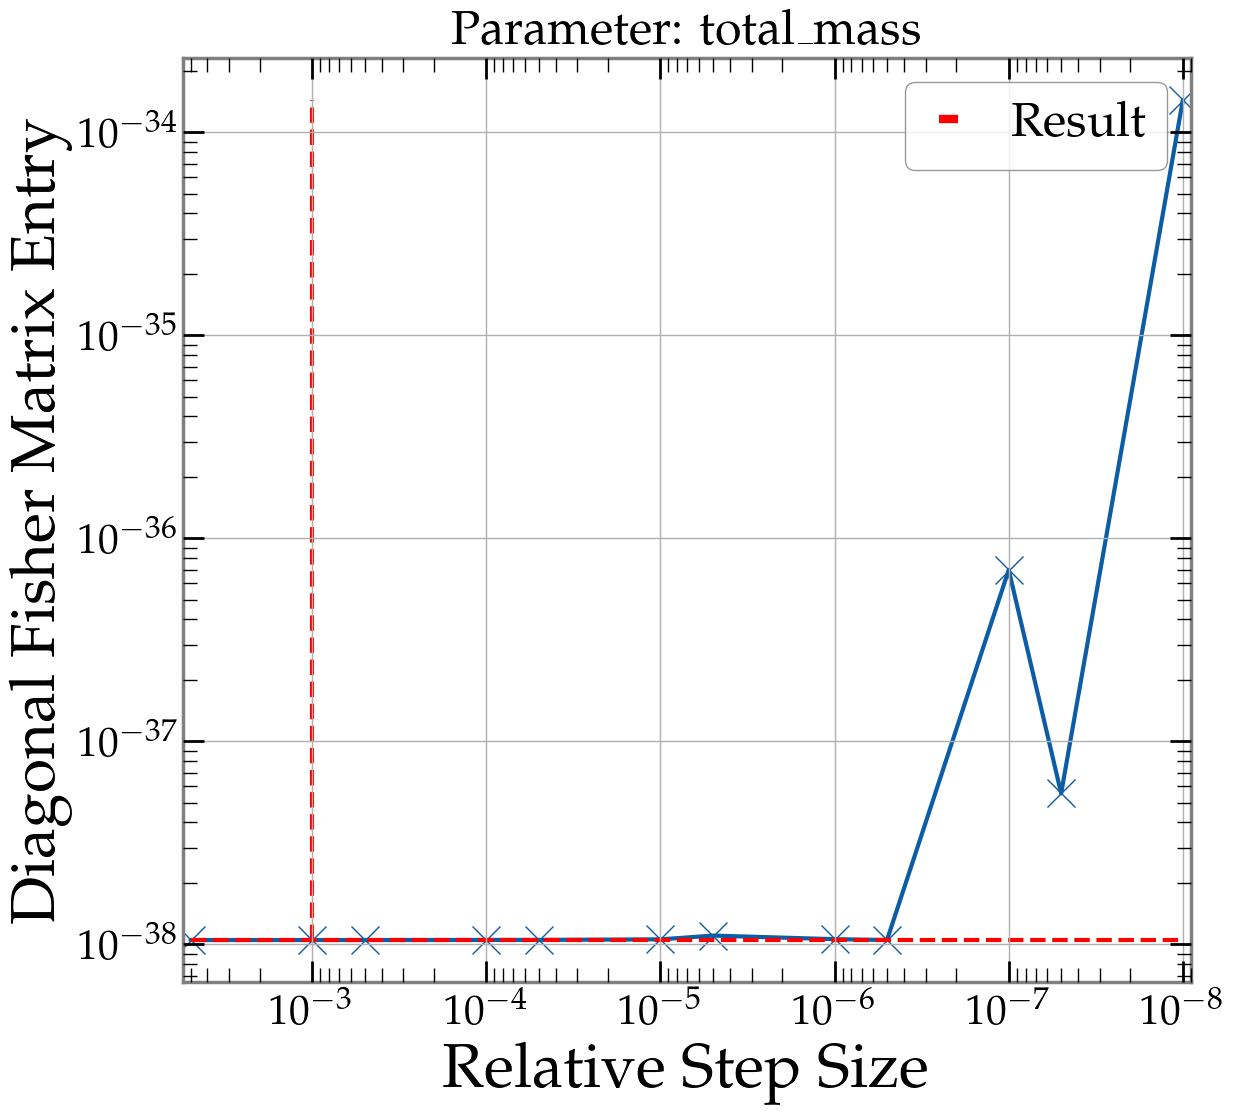

In [15]:
fisher_test_diff_crit = fisher_val_v3(
    wf_center_parameters,
    'total_mass',
    gen,
    step_sizes=more_step_sizes,
    convergence_check='diff_norm',
    convergence_plot=True
)


# fisher_test_diff_crit_2 = fisher_val_v3(
#     wf_center_parameters,
#     'total_mass',
#     gen,
#     step_sizes=more_step_sizes,
#     convergence_check='diff_norm',
#     convergence_threshold=0.0,  # Cannot be reached, want to see convergence
#     convergence_plot=True
# )

# We see convergence anyway for 'stem' check

XLAL Warning - XLALSimInspiralWaveformParamsLookupMass1 (LALSimInspiralWaveformParams.c:490): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupSymMassRatio (LALSimInspiralWaveformParams.c:869): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralGetMassRatioFromSymMassRatio (LALSimInspiralWaveformParams.c:427): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMass2 (LALSimInspiralWaveformParams.c:669): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code 

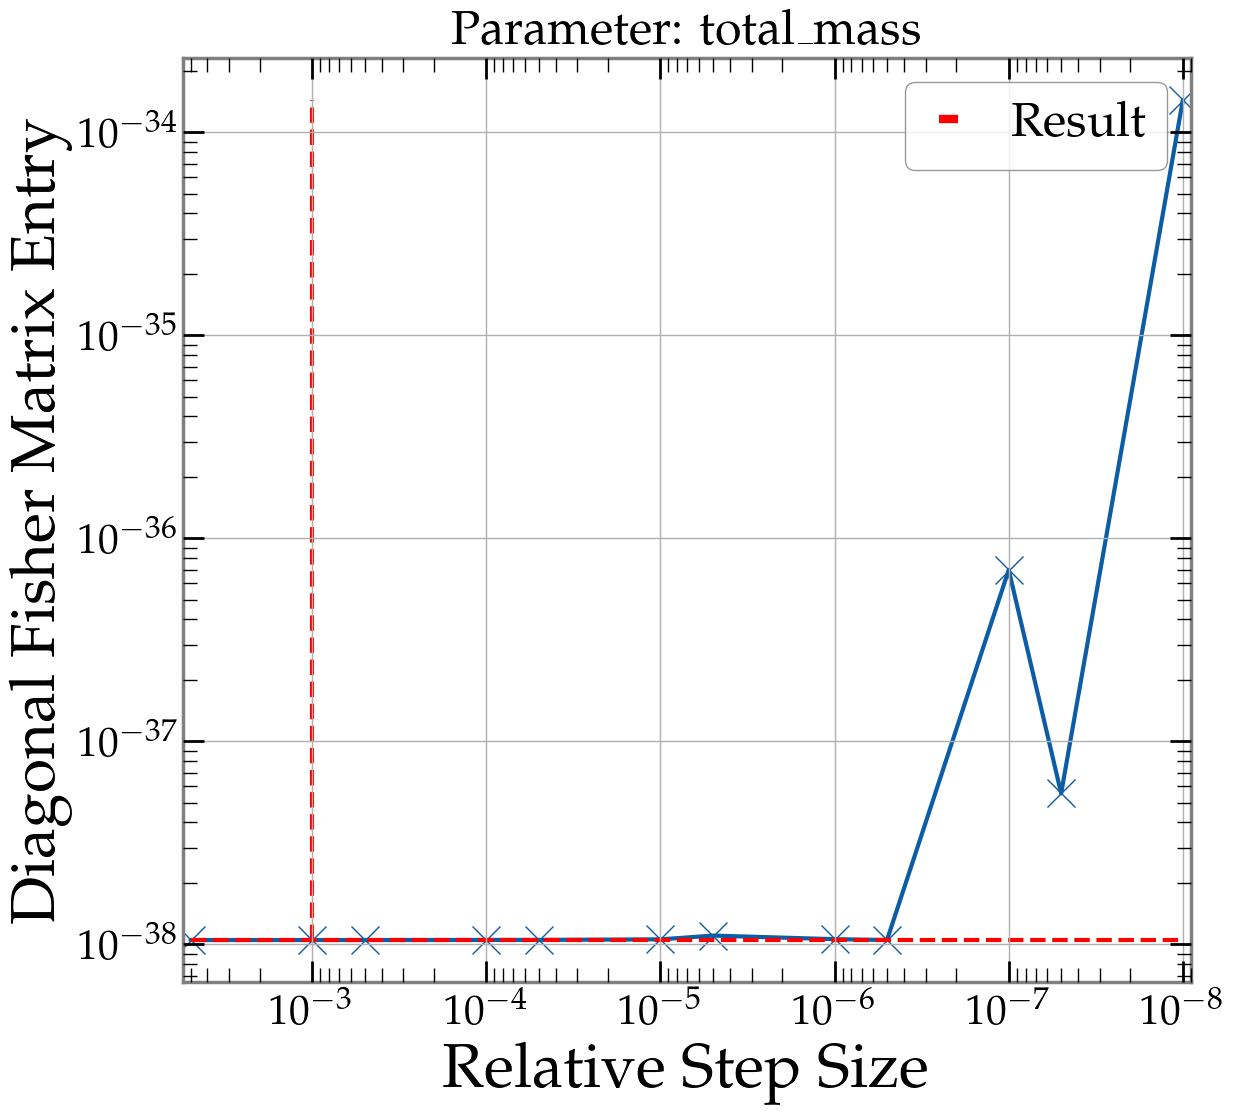

In [16]:
fisher_test_overlap_crit = fisher_val_v3(
    wf_center_parameters,
    'total_mass',
    gen,
    step_sizes=more_step_sizes,
    convergence_check='mismatch',
    convergence_plot=True
)


# fisher_test_overlap_crit_2 = fisher_val_v3(
#     wf_center_parameters,
#     'total_mass',
#     gen,
#     step_sizes=more_step_sizes,
#     convergence_check='mismatch',
#     convergence_threshold=0.0,  # Cannot be reached, want to see convergence
#     convergence_plot=True
# )

# We see convergence anyway for 'stem' check

XLAL Warning - XLALSimInspiralWaveformParamsLookupMass1 (LALSimInspiralWaveformParams.c:490): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupSymMassRatio (LALSimInspiralWaveformParams.c:869): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralGetMassRatioFromSymMassRatio (LALSimInspiralWaveformParams.c:427): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMass2 (LALSimInspiralWaveformParams.c:669): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code 

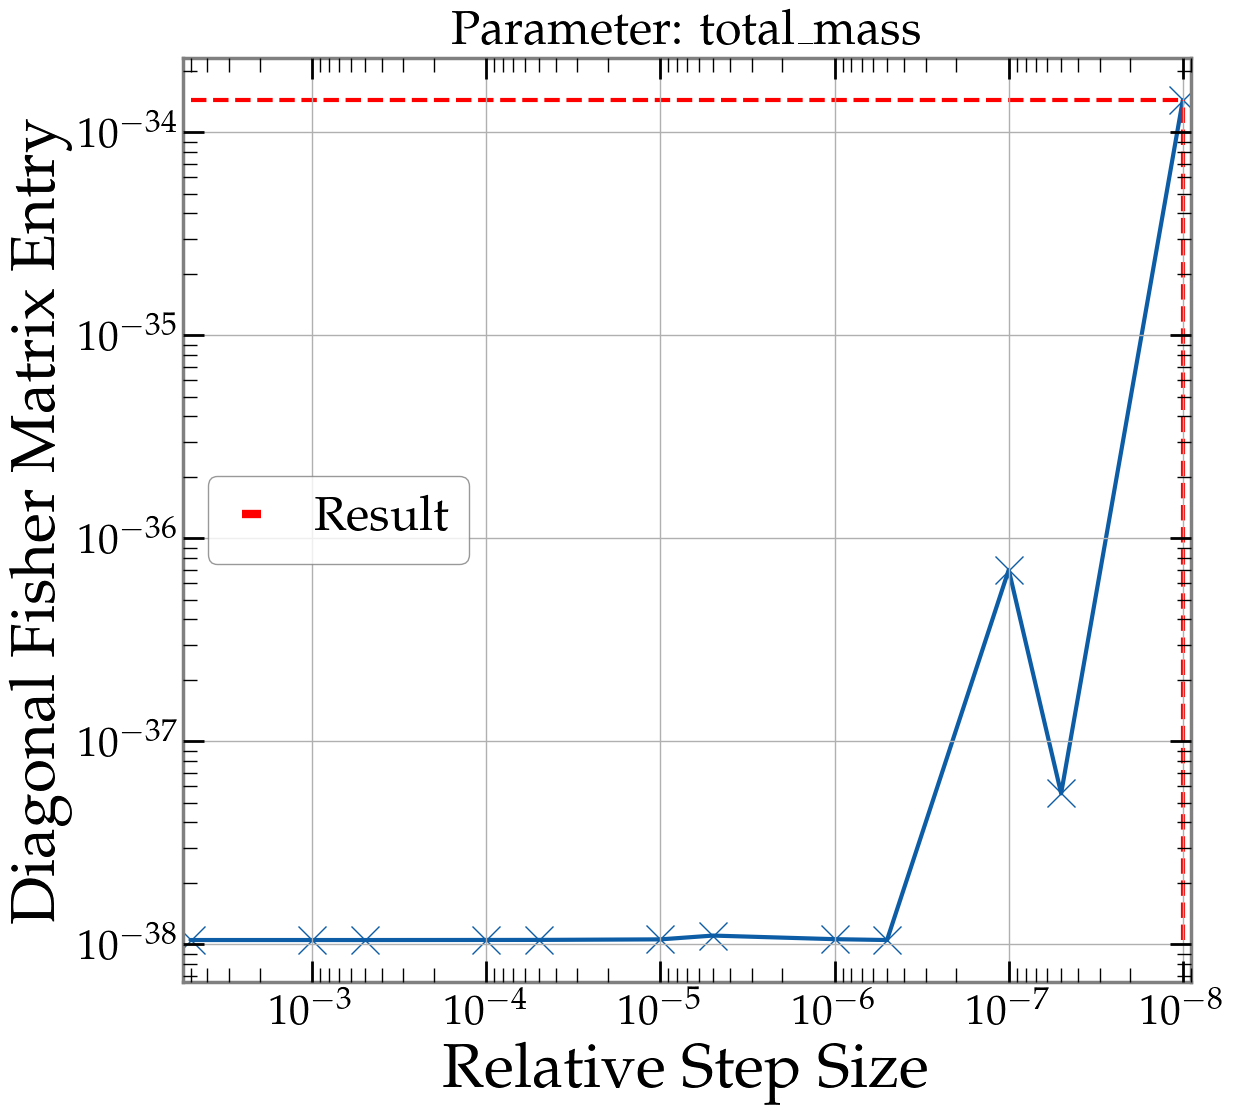

In [17]:
fisher_test_stem_crit = fisher_val_v3(
    wf_center_parameters,
    'total_mass',
    gen,
    step_sizes=more_step_sizes,
    convergence_check='stem',
    convergence_plot=True
)


# fisher_test_stem_crit_2 = fisher_val_v3(
#     wf_center_parameters,
#     'total_mass',
#     gen,
#     step_sizes=more_step_sizes,
#     convergence_check='stem',
#     convergence_threshold=0.0,  # Cannot be reached, want to see convergence
#     convergence_plot=True
# )

# We see convergence anyway for 'stem' check

Comparison of Estimates

In [18]:
print(fisher_test_rel_crit, fisher_test_diff_crit, fisher_test_overlap_crit, fisher_test_stem_crit)

[[<Quantity 1.05124933e-38 2.52923e-61 / (kg2 s2)>]] [[<Quantity 1.05124933e-38 2.52923e-61 / (kg2 s2)>]] [[<Quantity 1.05124933e-38 2.52923e-61 / (kg2 s2)>]] [[<Quantity 1.44461099e-34 2.52923e-61 / (kg2 s2)>]]


Very good

### Testing Different Parameters

In [19]:
conv_check_step_sizes = np.reshape(np.outer([1e-2, 1e-3, 1e-4, 1e-5, 1e-6], [5, 2, 1]), -1)
long_conv_check_step_sizes = np.reshape(np.outer([1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11, 1e-12], [5, 2, 1]), -1)

#### Symmetric Mass Ratio

In [44]:
# f_min = 10.*u.Hz  # Cutoff frequency
f_min = 20.*u.Hz  # Cutoff frequency
f_max = 1024. * u.Hz  # Cutoff from PSD
# delta_f = 2**-6 * u.Hz  # Actually works much better
delta_f = 2**-8 * u.Hz  # Actually works much better
delta_t = 1.0/4096.0 * u.s
f_ref = 20.*u.Hz  # Frequency where we specify spins
# f_ref = f_min  # Frequency where we specify spins
distance = 1.*u.Mpc
inclination = 0.0*u.rad  # Value taken from posteriors.ipynb, where posterior of inclination is plotted
phiRef = 0.*u.rad
eccentricity = 0.*u.dimensionless_unscaled
longAscNodes = 0.*u.rad
meanPerAno = 0.*u.rad


# Define the approximant
approximant = 'IMRPhenomXPHM'
# approximant = 'SEOBNRv4'

# Initialize the generator
gen = wfm.LALCompactBinaryCoalescenceGenerator(approximant)

sym_mass_ratio_check_params = {
    'total_mass': 42.*u.solMass,
    'sym_mass_ratio': 0.05*u.dimensionless_unscaled,
    # 'sym_mass_ratio': 0.15*u.dimensionless_unscaled,
    'f22_start' : f_min,
    'f_max' : f_max,
    'deltaT' : delta_t,
    'deltaF' : delta_f,
    'f22_ref': f_ref,
    'phi_ref' : phiRef,
    'distance' : distance,
    'inclination' : inclination,
    'eccentricity' : eccentricity,
    'longAscNodes' : longAscNodes,
    'meanPerAno' : meanPerAno,
    'condition' : 0
    # 'condition' : 1  # Needs to be on for SEOB
}

/home/user/miniconda3/envs/gw_signal_tools/lib/python3.11/site-packages/lalsimulation/gwsignal/core/utils.py:277: UserWarning: The larger object cannot be determined, assuming m1 >= m2.
  warnings.warn(warn_string)
XLAL Warning - XLALSimInspiralWaveformParamsLookupMass1 (LALSimInspiralWaveformParams.c:490): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupSymMassRatio (LALSimInspiralWaveformParams.c:869): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralGetMassRatioFromSymMassRatio (LALSimInspiralWaveformParams.c:427): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWavefo

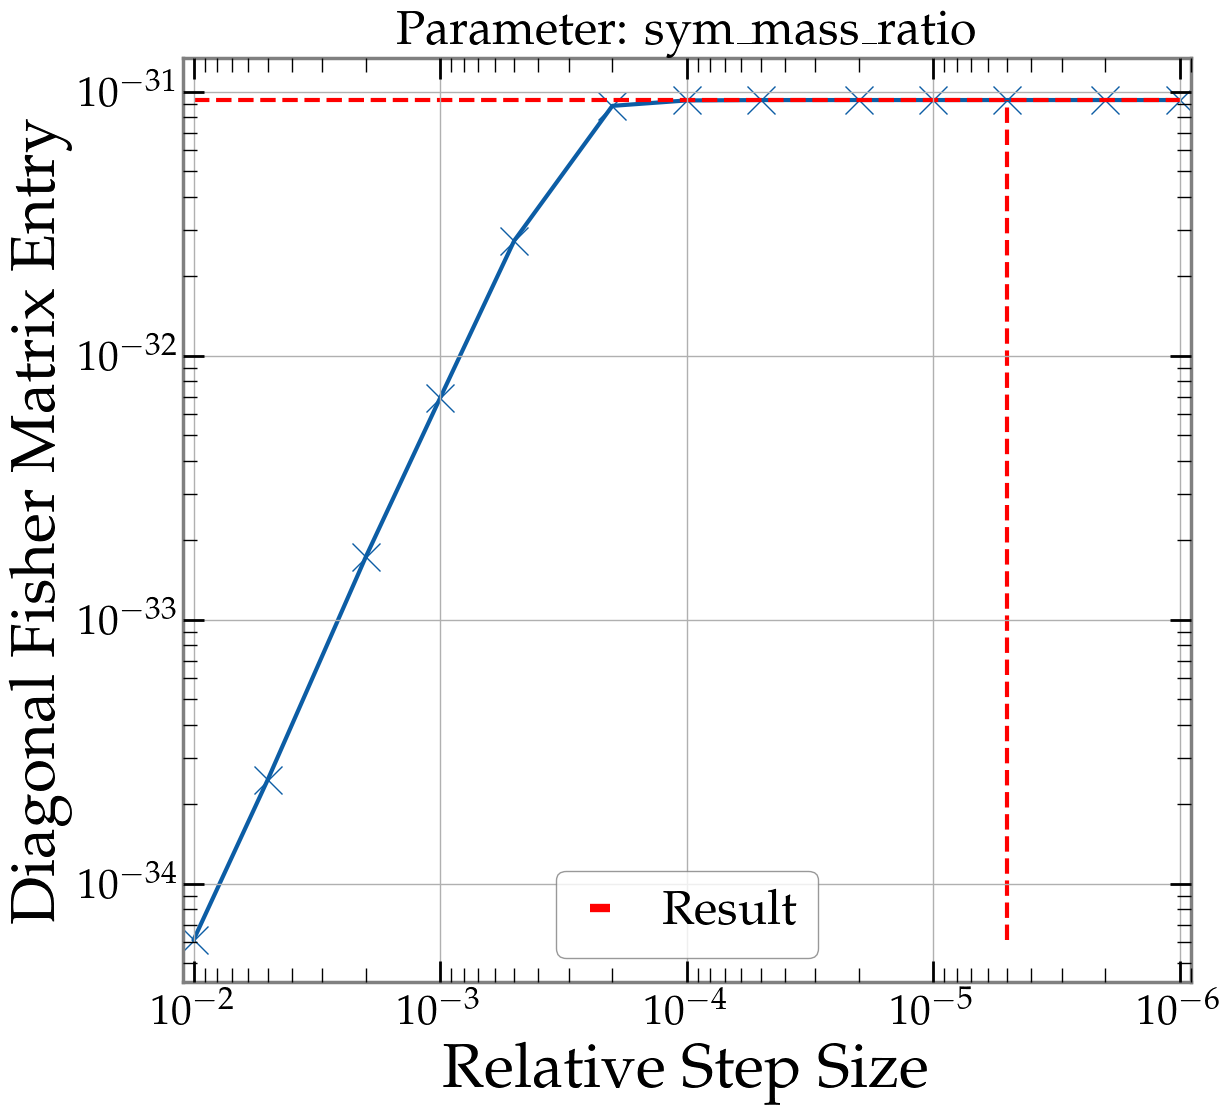

XLAL Warning - XLALSimInspiralWaveformParamsLookupMass1 (LALSimInspiralWaveformParams.c:490): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupSymMassRatio (LALSimInspiralWaveformParams.c:869): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralGetMassRatioFromSymMassRatio (LALSimInspiralWaveformParams.c:427): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMass2 (LALSimInspiralWaveformParams.c:669): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code 

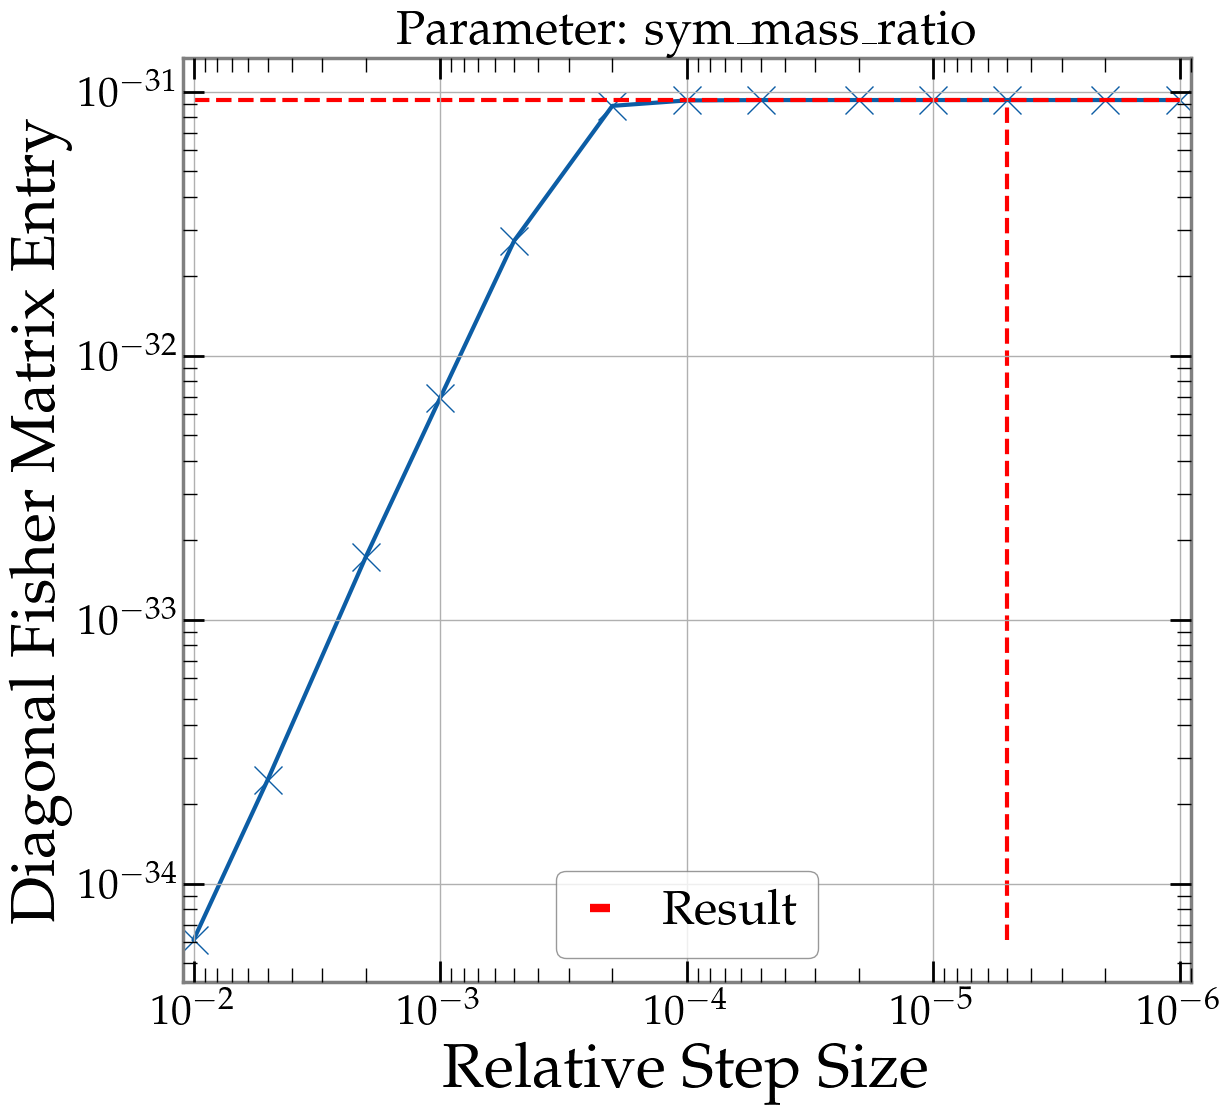

XLAL Warning - XLALSimInspiralWaveformParamsLookupMass1 (LALSimInspiralWaveformParams.c:490): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupSymMassRatio (LALSimInspiralWaveformParams.c:869): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralGetMassRatioFromSymMassRatio (LALSimInspiralWaveformParams.c:427): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMass2 (LALSimInspiralWaveformParams.c:669): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code 

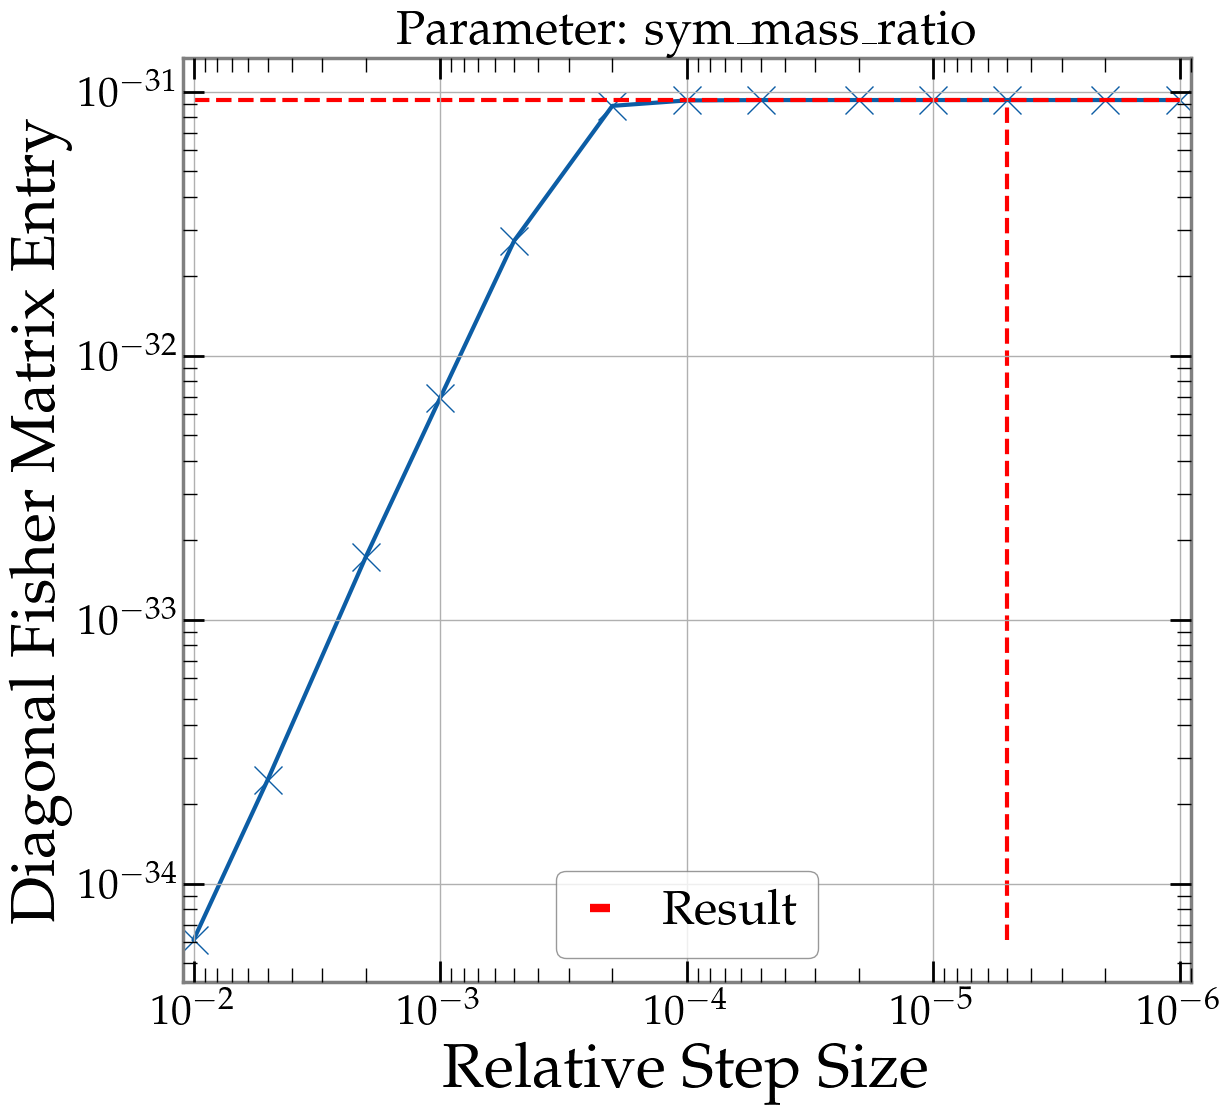

XLAL Warning - XLALSimInspiralWaveformParamsLookupMass1 (LALSimInspiralWaveformParams.c:490): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupSymMassRatio (LALSimInspiralWaveformParams.c:869): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralGetMassRatioFromSymMassRatio (LALSimInspiralWaveformParams.c:427): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMass2 (LALSimInspiralWaveformParams.c:669): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code 

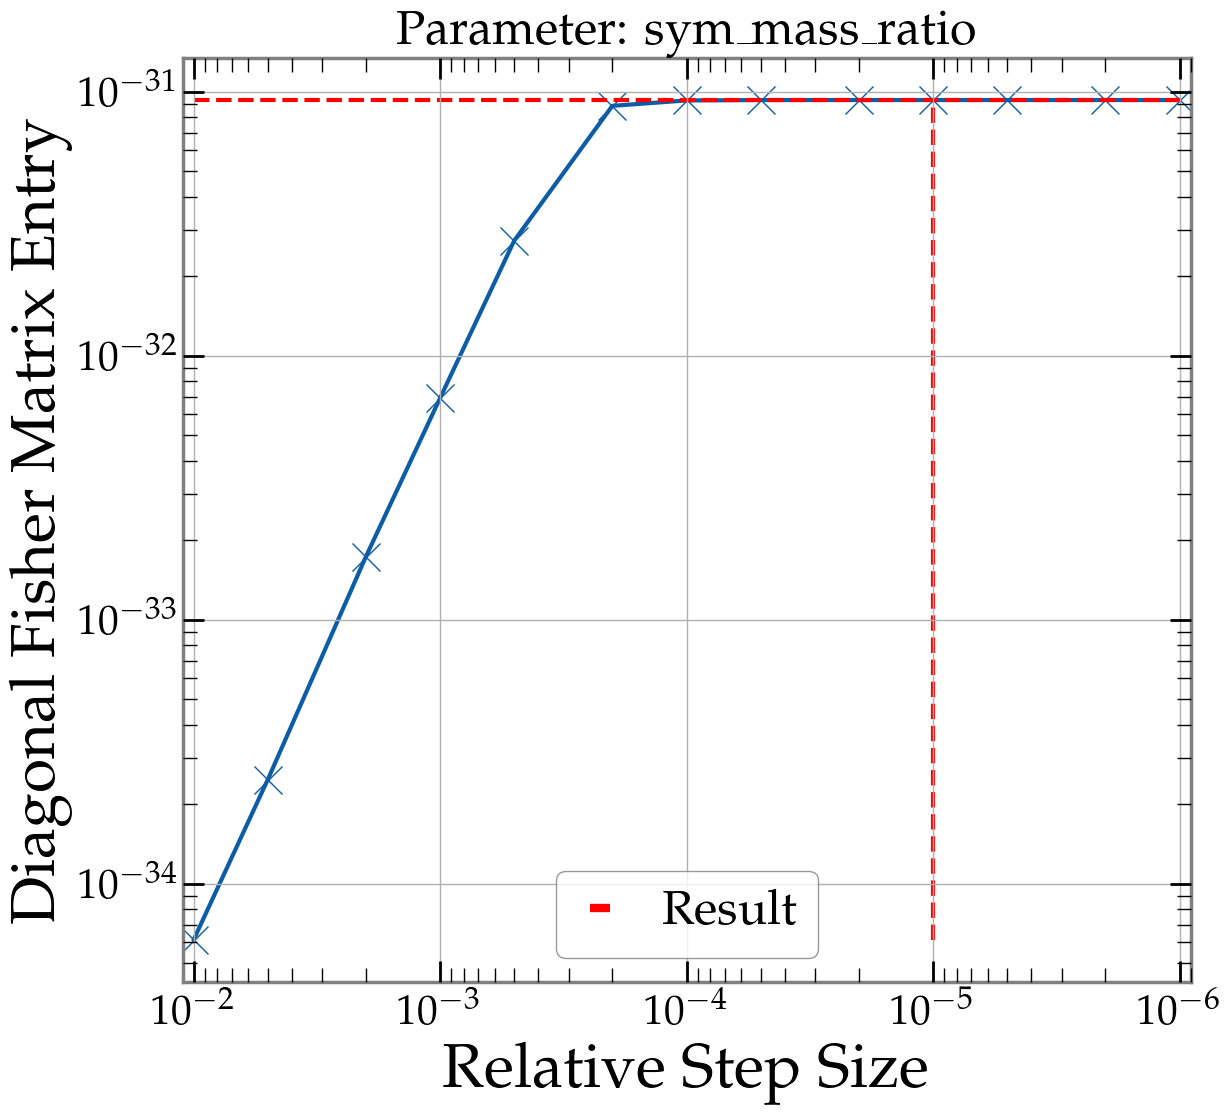

In [46]:
fisher_vals_sym_mass_ratio = []

for check in ['rel_deviation', 'diff_norm', 'mismatch', 'stem']:
    fisher_test_val = fisher_val_v3(
        sym_mass_ratio_check_params,
        'sym_mass_ratio',
        gen,
        convergence_check=check,
        # convergence_threshold=0.0,
        convergence_plot=True,
        step_sizes=conv_check_step_sizes[2:]  # For eta=0.05, otherwise we get too close to eta=0
    )

    fisher_vals_sym_mass_ratio += [fisher_test_val]

In [22]:
print(fisher_vals_sym_mass_ratio)

[[[<Quantity 6.96468953e-33 1 / s2>]], [[<Quantity 6.96468953e-33 1 / s2>]], [[<Quantity 6.96468953e-33 1 / s2>]], [[<Quantity 6.96468953e-33 1 / s2>]]]


XLAL Warning - XLALSimInspiralWaveformParamsLookupMass1 (LALSimInspiralWaveformParams.c:490): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupSymMassRatio (LALSimInspiralWaveformParams.c:869): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralGetMassRatioFromSymMassRatio (LALSimInspiralWaveformParams.c:427): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMass2 (LALSimInspiralWaveformParams.c:669): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code 

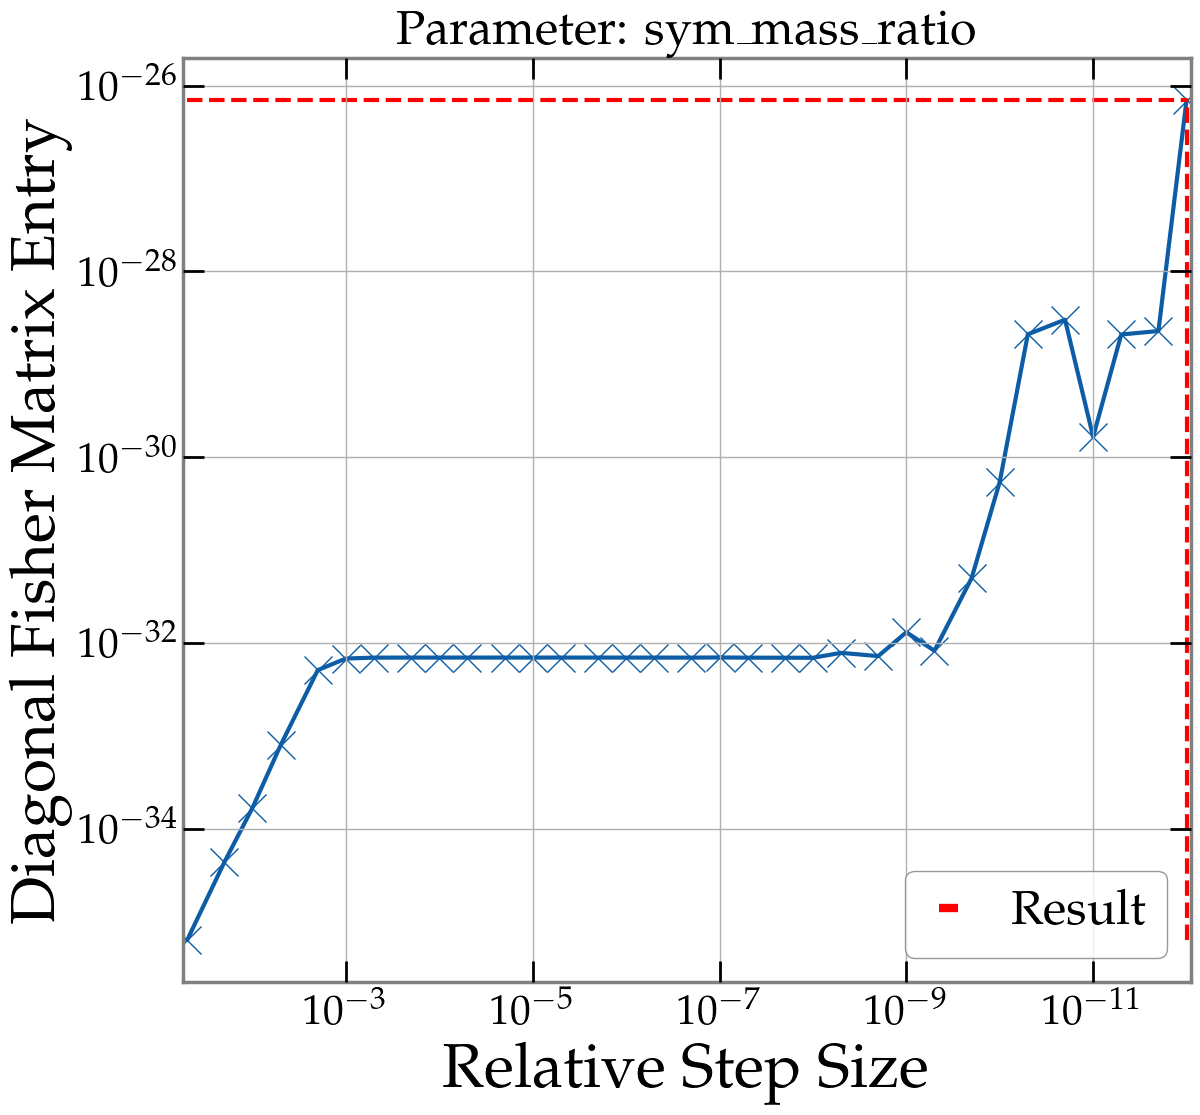

In [23]:
fisher_test_val = fisher_val_v3(
    sym_mass_ratio_check_params,
    'sym_mass_ratio',
    gen,
    # step_sizes=conv_check_step_sizes,
    step_sizes=long_conv_check_step_sizes,
    convergence_check='stem',
    break_upon_convergence=False,
    convergence_plot=True
)

Hmmm, this behaviour should indicate that most stable version is around 1e-3, right? Because best value at 1e-12 does not make sense

-> I think in that regime, no change in waveform takes place and for this reason, the result simply increases directly as h is increased (because we divide by h)

-> plus: point we chose for evaluation was very tough, unequal mass ratios; better for 0.15 instead 0.05

XLAL Warning - XLALSimInspiralWaveformParamsLookupMass1 (LALSimInspiralWaveformParams.c:490): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupSymMassRatio (LALSimInspiralWaveformParams.c:869): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralGetMassRatioFromSymMassRatio (LALSimInspiralWaveformParams.c:427): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMass2 (LALSimInspiralWaveformParams.c:669): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code 

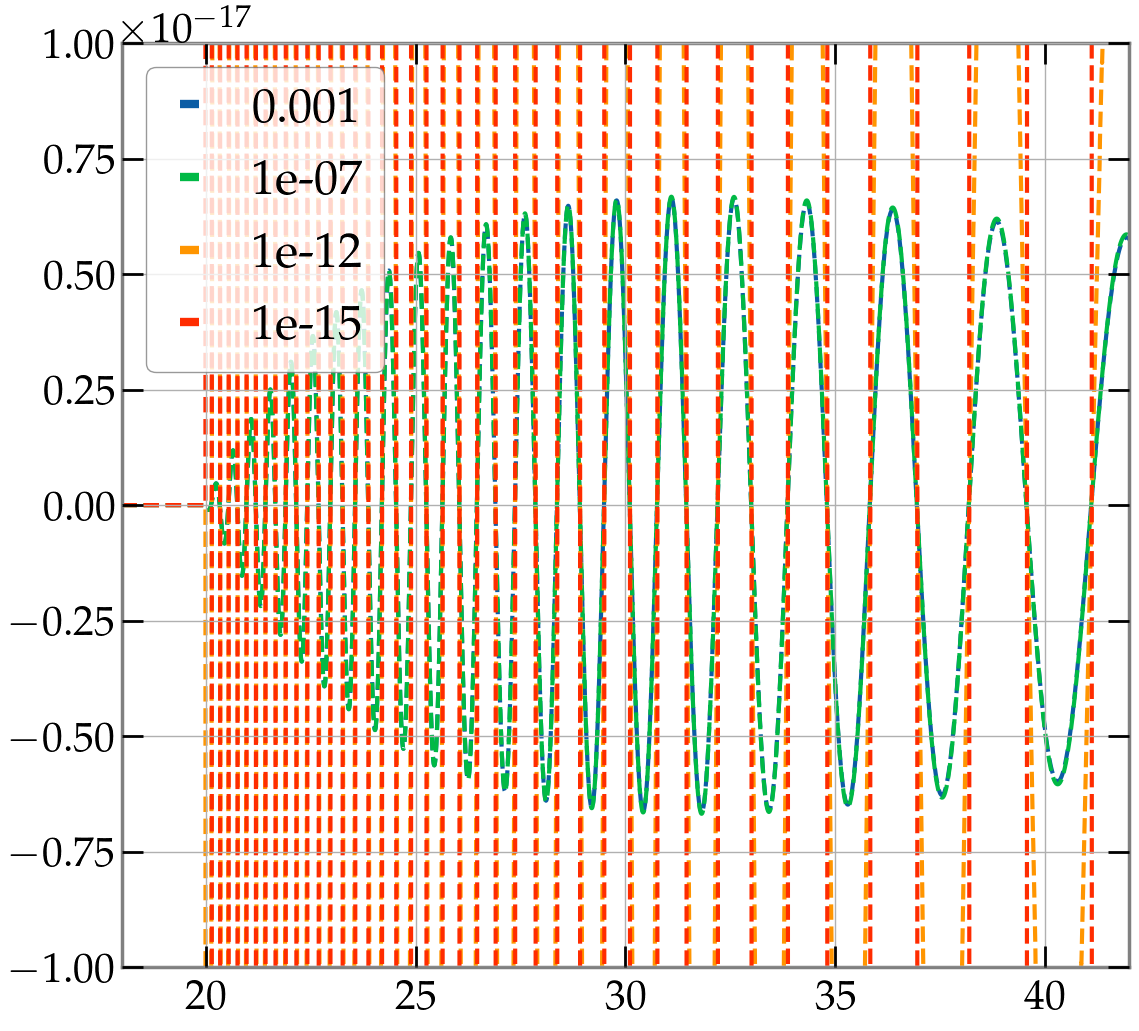

In [24]:
# for test_step_size in [1e-3, 1e-7]:  # Testing good estimates -> agree very well
for test_step_size in [1e-3, 1e-7, 1e-12, 1e-15]:
    deriv = get_waveform_derivative_1D(
        sym_mass_ratio_check_params,
        'sym_mass_ratio',
        gen,
        test_step_size
    )

    plt.plot(deriv, '--', label=f'{test_step_size}')


plt.legend()
plt.xlim([18, 42])
# plt.ylim([-1e-15, 1e-15])
plt.ylim([-1e-17, 1e-17])

# plt.yscale('log')

plt.show()

#### Mass Ratio

In [25]:
# f_min = 10.*u.Hz  # Cutoff frequency
f_min = 20.*u.Hz  # Cutoff frequency
f_max = 1024. * u.Hz  # Cutoff from PSD
# delta_f = 2**-6 * u.Hz  # Actually works much better
delta_f = 2**-8 * u.Hz  # Actually works much better
delta_t = 1.0/4096.0 * u.s
f_ref = 20.*u.Hz  # Frequency where we specify spins
# f_ref = f_min  # Frequency where we specify spins
distance = 1.*u.Mpc
inclination = 0.0*u.rad  # Value taken from posteriors.ipynb, where posterior of inclination is plotted
phiRef = 0.*u.rad
eccentricity = 0.*u.dimensionless_unscaled
longAscNodes = 0.*u.rad
meanPerAno = 0.*u.rad


# Define the approximant
approximant = 'IMRPhenomXPHM'
# approximant = 'SEOBNRv4'

# Initialize the generator
gen = wfm.LALCompactBinaryCoalescenceGenerator(approximant)

mass_ratio_check_params = {
    'total_mass': 42.*u.solMass,
    'mass_ratio': 0.5*u.dimensionless_unscaled,
    'f22_start' : f_min,
    'f_max' : f_max,
    'deltaT' : delta_t,
    'deltaF' : delta_f,
    'f22_ref': f_ref,
    'phi_ref' : phiRef,
    'distance' : distance,
    'inclination' : inclination,
    'eccentricity' : eccentricity,
    'longAscNodes' : longAscNodes,
    'meanPerAno' : meanPerAno,
    'condition' : 0
    # 'condition' : 1  # Needs to be on for SEOB
}

XLAL Warning - XLALSimInspiralWaveformParamsLookupMass1 (LALSimInspiralWaveformParams.c:490): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMassRatio (LALSimInspiralWaveformParams.c:851): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMass2 (LALSimInspiralWaveformParams.c:669): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is

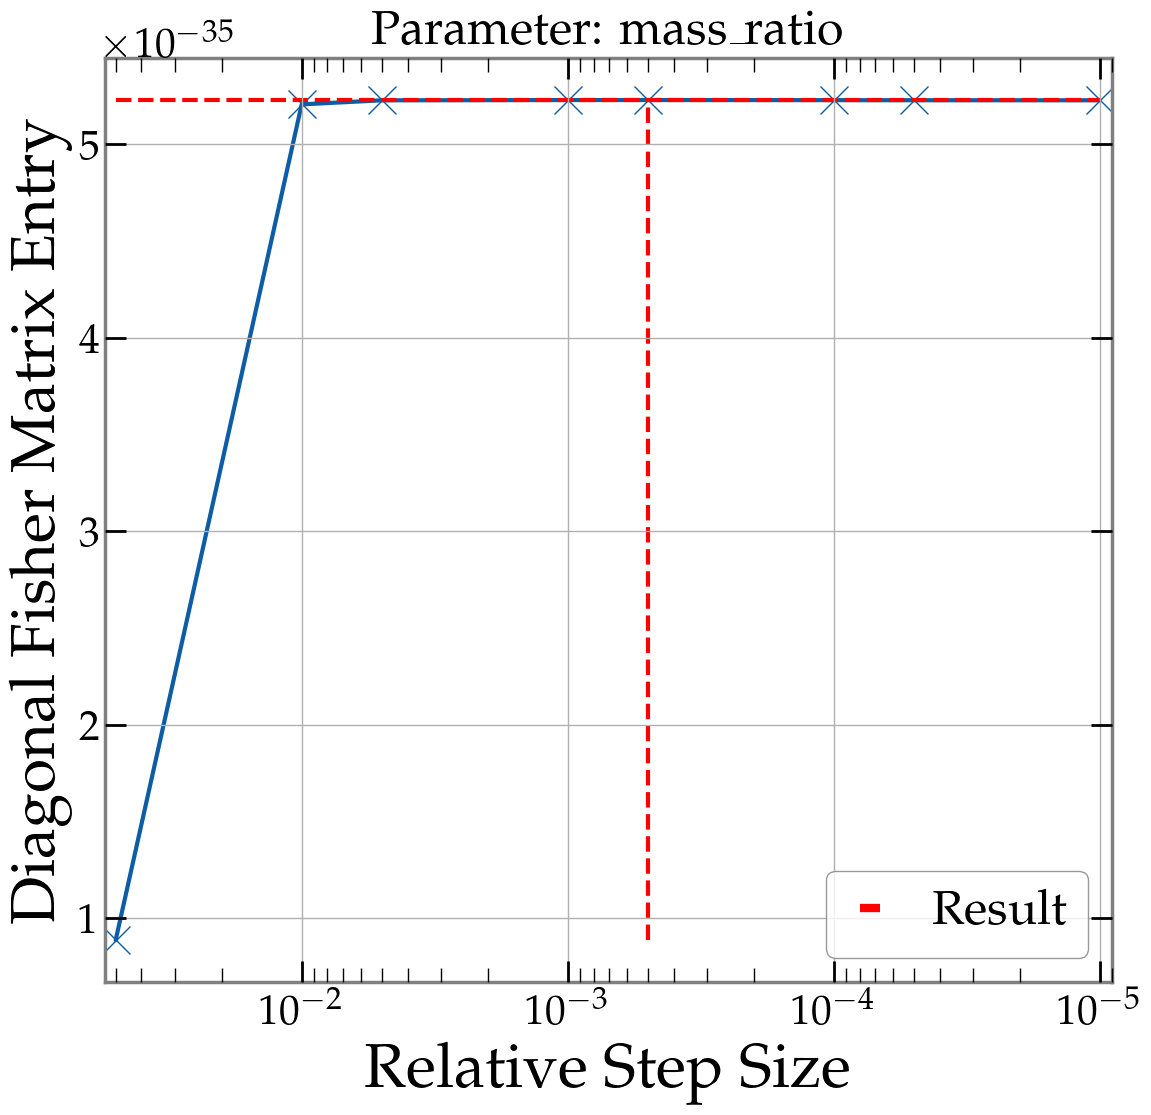

XLAL Warning - XLALSimInspiralWaveformParamsLookupMass1 (LALSimInspiralWaveformParams.c:490): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMassRatio (LALSimInspiralWaveformParams.c:851): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMass2 (LALSimInspiralWaveformParams.c:669): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is

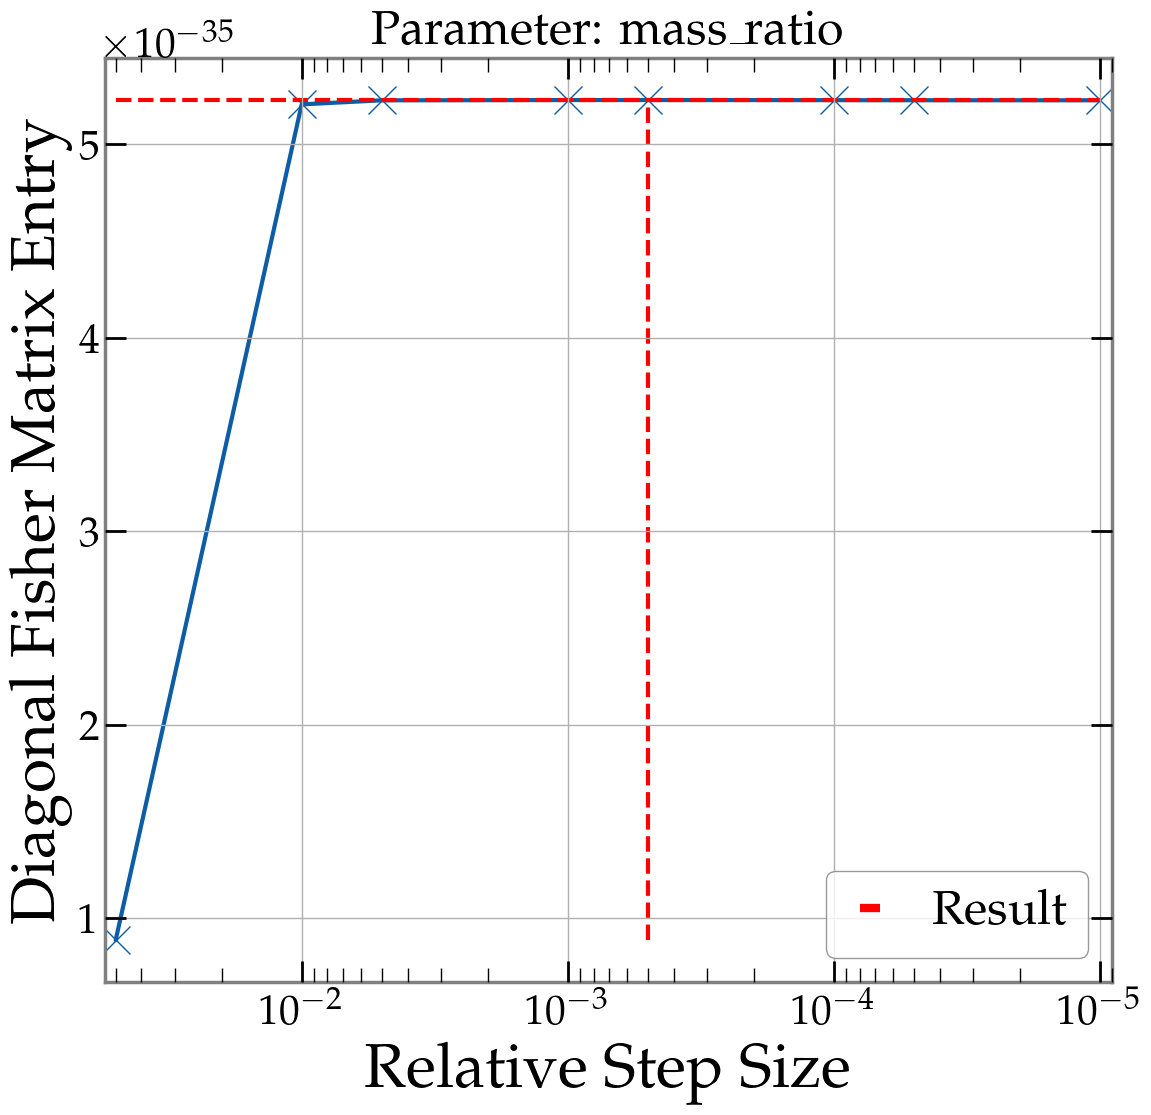

XLAL Warning - XLALSimInspiralWaveformParamsLookupMass1 (LALSimInspiralWaveformParams.c:490): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMassRatio (LALSimInspiralWaveformParams.c:851): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMass2 (LALSimInspiralWaveformParams.c:669): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is

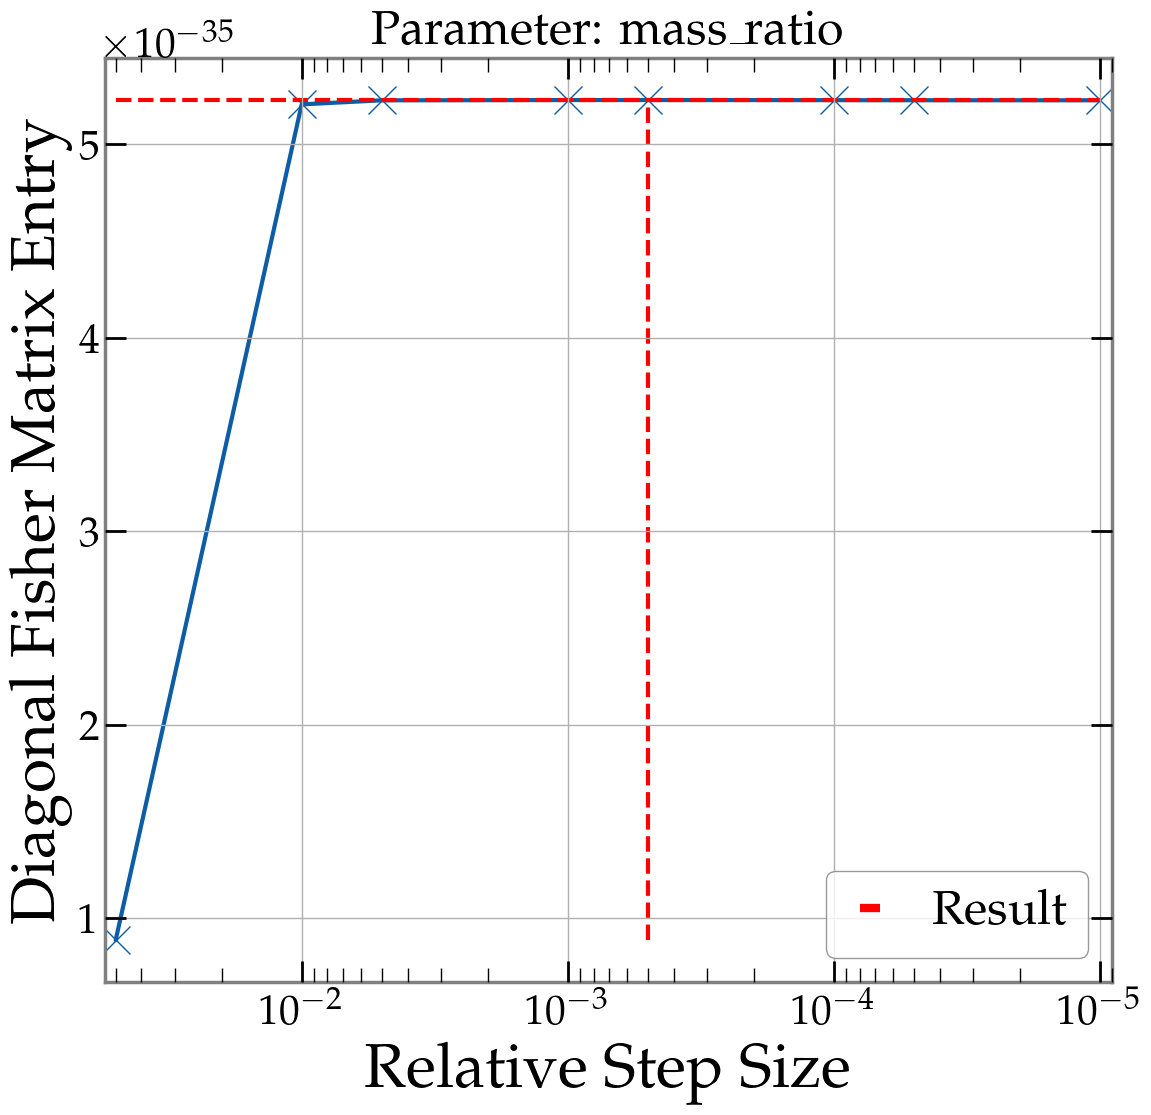

XLAL Warning - XLALSimInspiralWaveformParamsLookupMass1 (LALSimInspiralWaveformParams.c:490): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMassRatio (LALSimInspiralWaveformParams.c:851): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMass2 (LALSimInspiralWaveformParams.c:669): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is

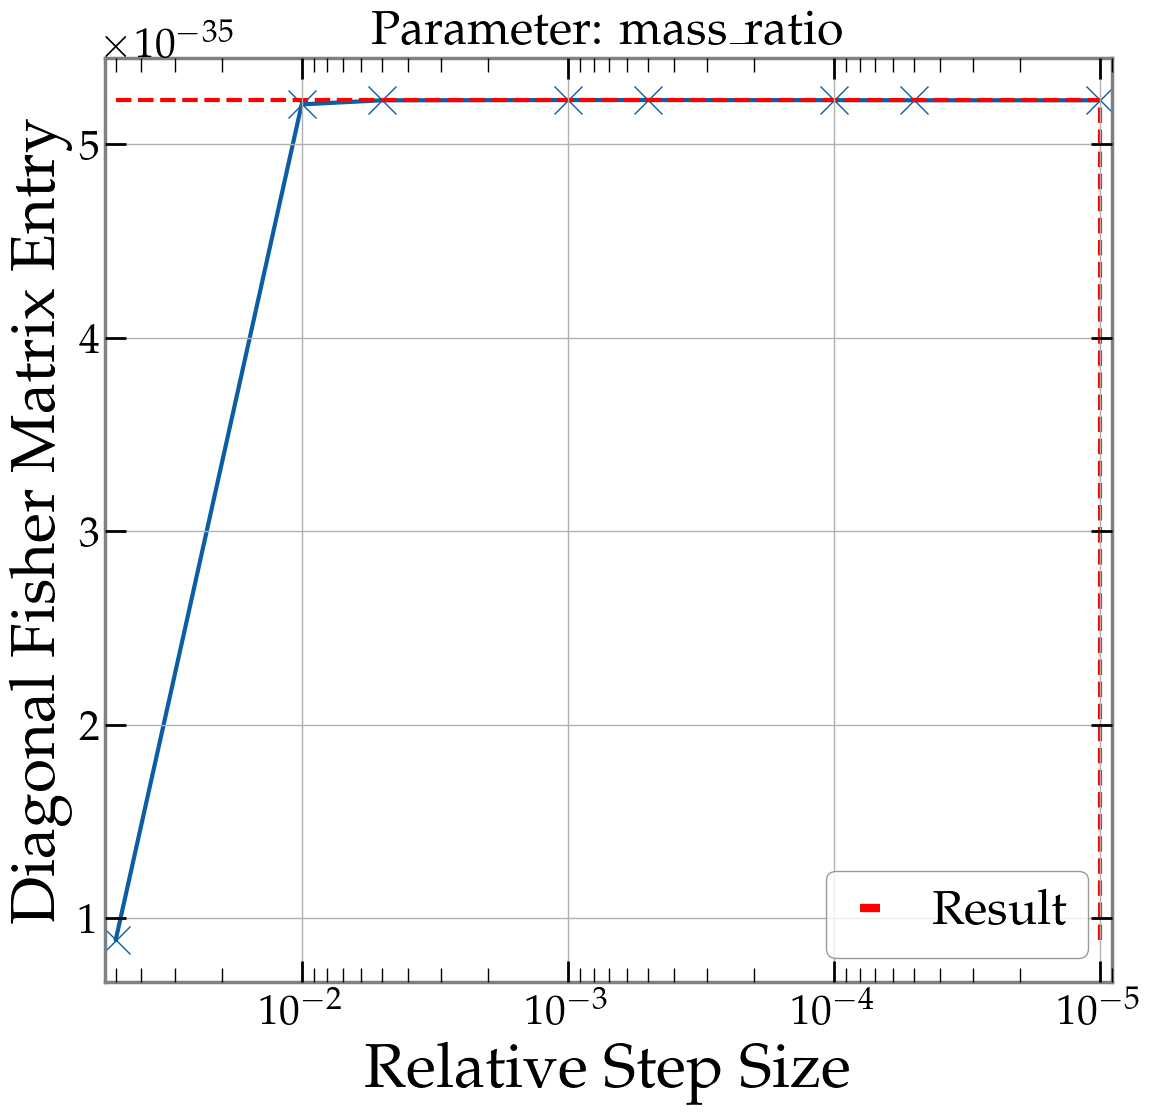

In [26]:
fisher_vals_mass_ratio = []

for check in ['rel_deviation', 'diff_norm', 'mismatch', 'stem']:
    fisher_test_val = fisher_val_v3(
        mass_ratio_check_params,
        'mass_ratio',
        gen,
        convergence_check=check,
        # convergence_threshold=0.0,
        convergence_plot=True
    )

    fisher_vals_mass_ratio += [fisher_test_val]

In [27]:
print(fisher_vals_mass_ratio)

[[[<Quantity 5.22868191e-35 1 / s2>]], [[<Quantity 5.22868191e-35 1 / s2>]], [[<Quantity 5.22868191e-35 1 / s2>]], [[<Quantity 5.22741416e-35 1 / s2>]]]


XLAL Warning - XLALSimInspiralWaveformParamsLookupMass1 (LALSimInspiralWaveformParams.c:490): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMassRatio (LALSimInspiralWaveformParams.c:851): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMass2 (LALSimInspiralWaveformParams.c:669): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is

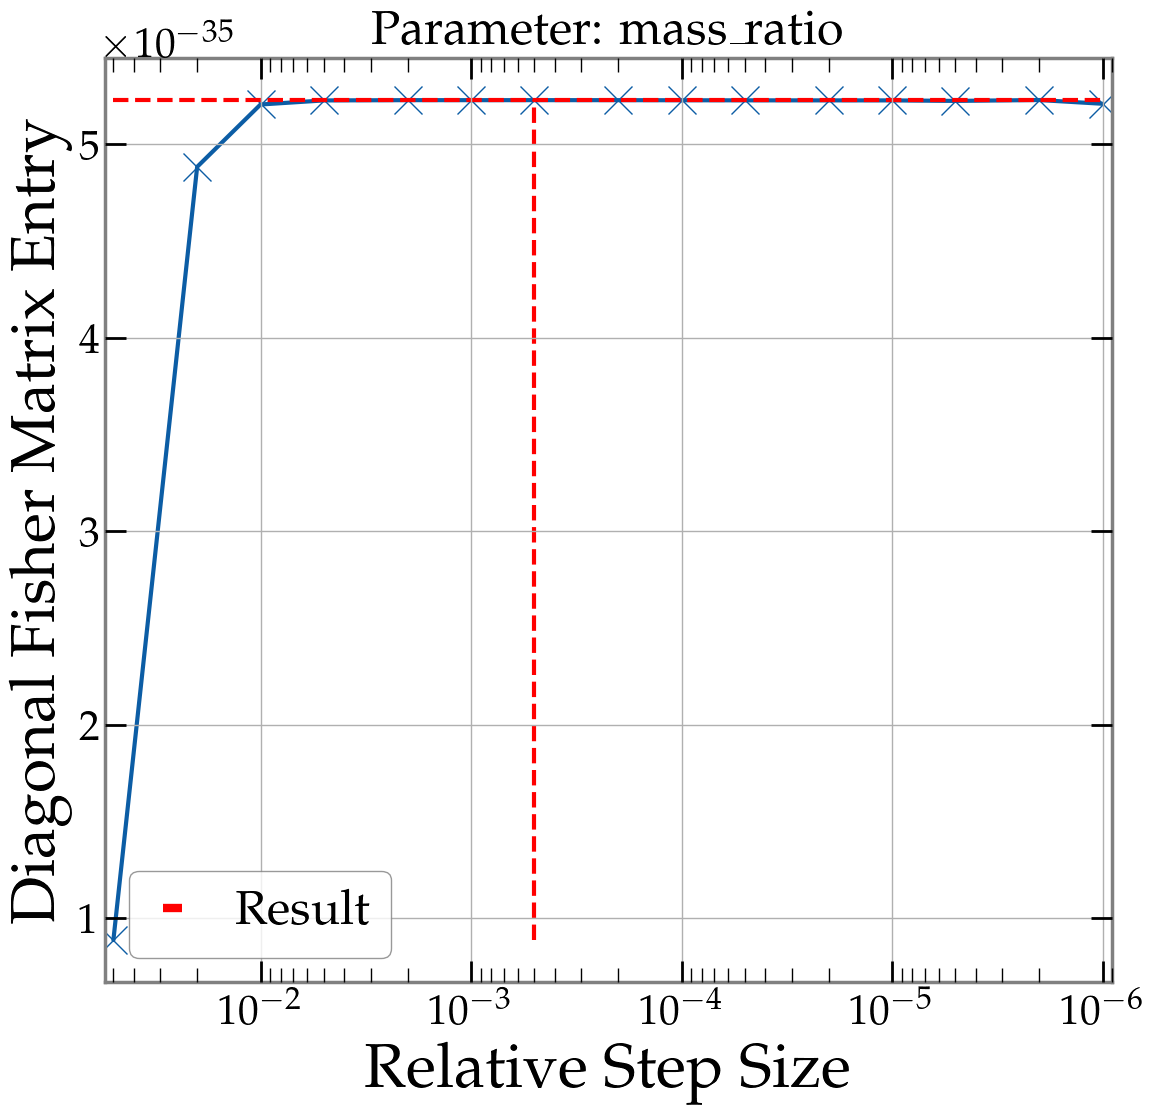

In [28]:
fisher_test_val = fisher_val_v3(
    mass_ratio_check_params,
    'mass_ratio',
    gen,
    step_sizes=conv_check_step_sizes,
    convergence_check='stem',
    break_upon_convergence=False,
    convergence_plot=True
)

#### Spin1z

In [29]:
# f_min = 10.*u.Hz  # Cutoff frequency
f_min = 20.*u.Hz  # Cutoff frequency
f_max = 1024. * u.Hz  # Cutoff from PSD
# delta_f = 2**-6 * u.Hz  # Actually works much better
delta_f = 2**-8 * u.Hz  # Actually works much better
delta_t = 1.0/4096.0 * u.s
f_ref = 20.*u.Hz  # Frequency where we specify spins
# f_ref = f_min  # Frequency where we specify spins
distance = 1.*u.Mpc
inclination = 0.0*u.rad  # Value taken from posteriors.ipynb, where posterior of inclination is plotted
phiRef = 0.*u.rad
eccentricity = 0.*u.dimensionless_unscaled
longAscNodes = 0.*u.rad
meanPerAno = 0.*u.rad


# Define the approximant
approximant = 'IMRPhenomXPHM'
# approximant = 'SEOBNRv4'

# Initialize the generator
gen = wfm.LALCompactBinaryCoalescenceGenerator(approximant)

spin1z_check_params = {
    'total_mass': 42.*u.solMass,
    'mass_ratio': 0.5*u.dimensionless_unscaled,
    'spin1z': 0.2*u.dimensionless_unscaled,
    'f22_start' : f_min,
    'f_max' : f_max,
    'deltaT' : delta_t,
    'deltaF' : delta_f,
    'f22_ref': f_ref,
    'phi_ref' : phiRef,
    'distance' : distance,
    'inclination' : inclination,
    'eccentricity' : eccentricity,
    'longAscNodes' : longAscNodes,
    'meanPerAno' : meanPerAno,
    'condition' : 0
    # 'condition' : 1  # Needs to be on for SEOB
}

XLAL Warning - XLALSimInspiralWaveformParamsLookupMass1 (LALSimInspiralWaveformParams.c:490): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMassRatio (LALSimInspiralWaveformParams.c:851): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMass2 (LALSimInspiralWaveformParams.c:669): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is

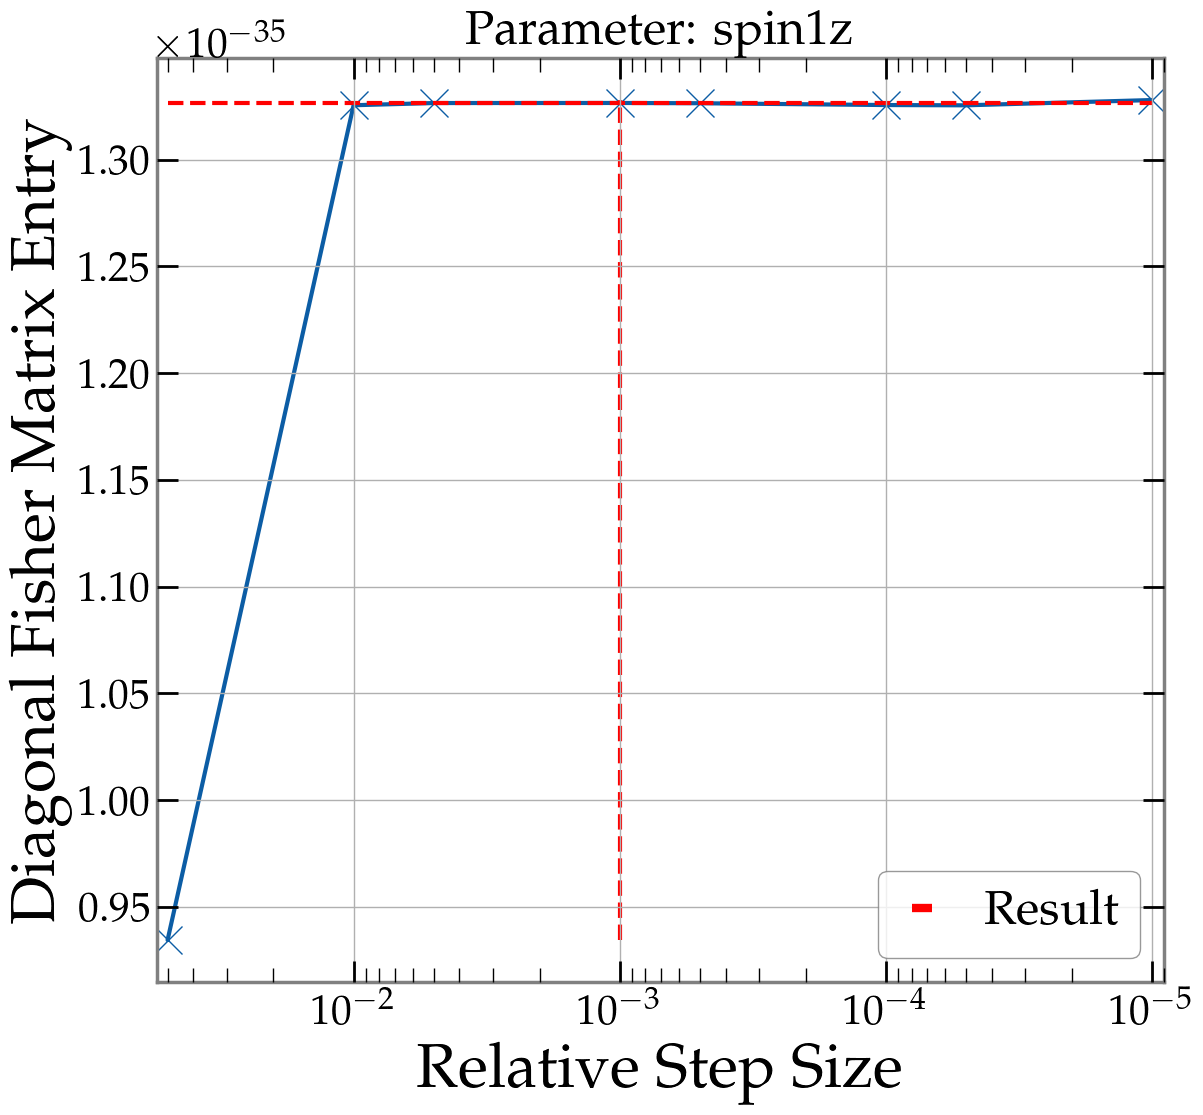

XLAL Warning - XLALSimInspiralWaveformParamsLookupMass1 (LALSimInspiralWaveformParams.c:490): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMassRatio (LALSimInspiralWaveformParams.c:851): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMass2 (LALSimInspiralWaveformParams.c:669): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is

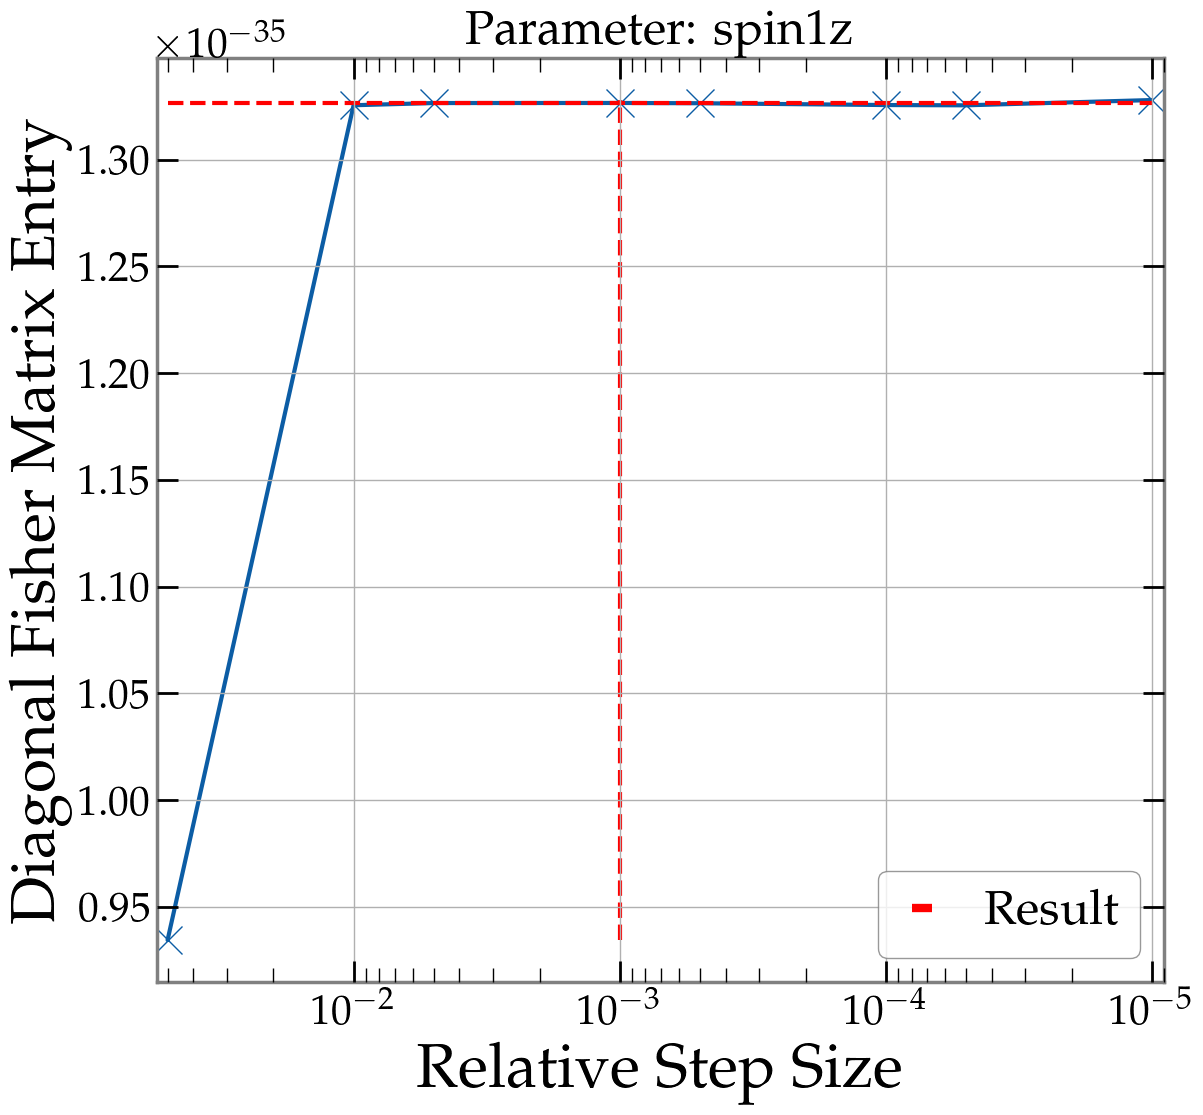

XLAL Warning - XLALSimInspiralWaveformParamsLookupMass1 (LALSimInspiralWaveformParams.c:490): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMassRatio (LALSimInspiralWaveformParams.c:851): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMass2 (LALSimInspiralWaveformParams.c:669): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is

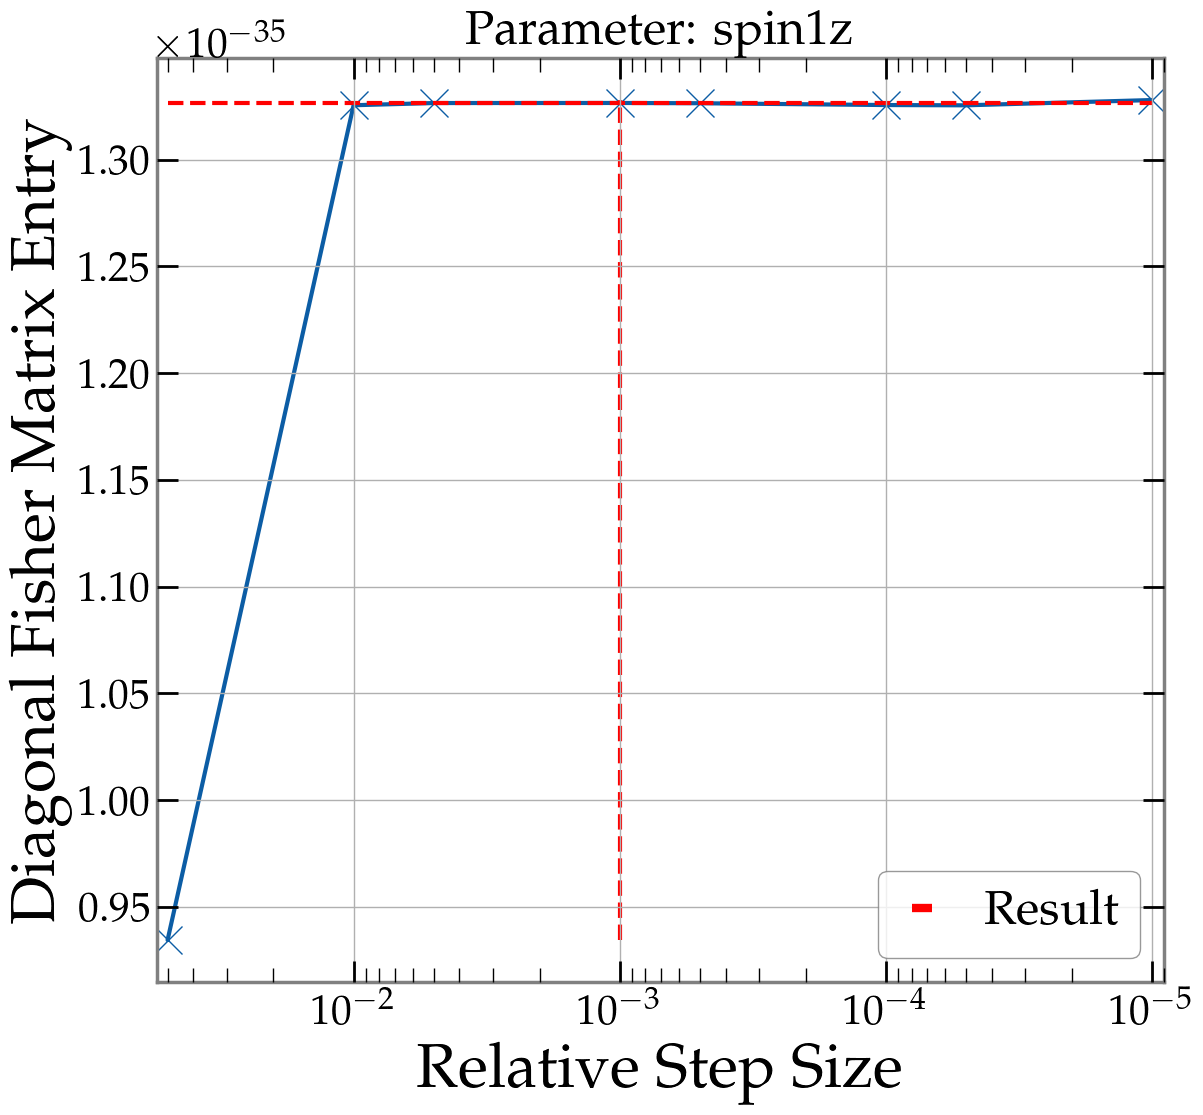

XLAL Warning - XLALSimInspiralWaveformParamsLookupMass1 (LALSimInspiralWaveformParams.c:490): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMassRatio (LALSimInspiralWaveformParams.c:851): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMass2 (LALSimInspiralWaveformParams.c:669): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is

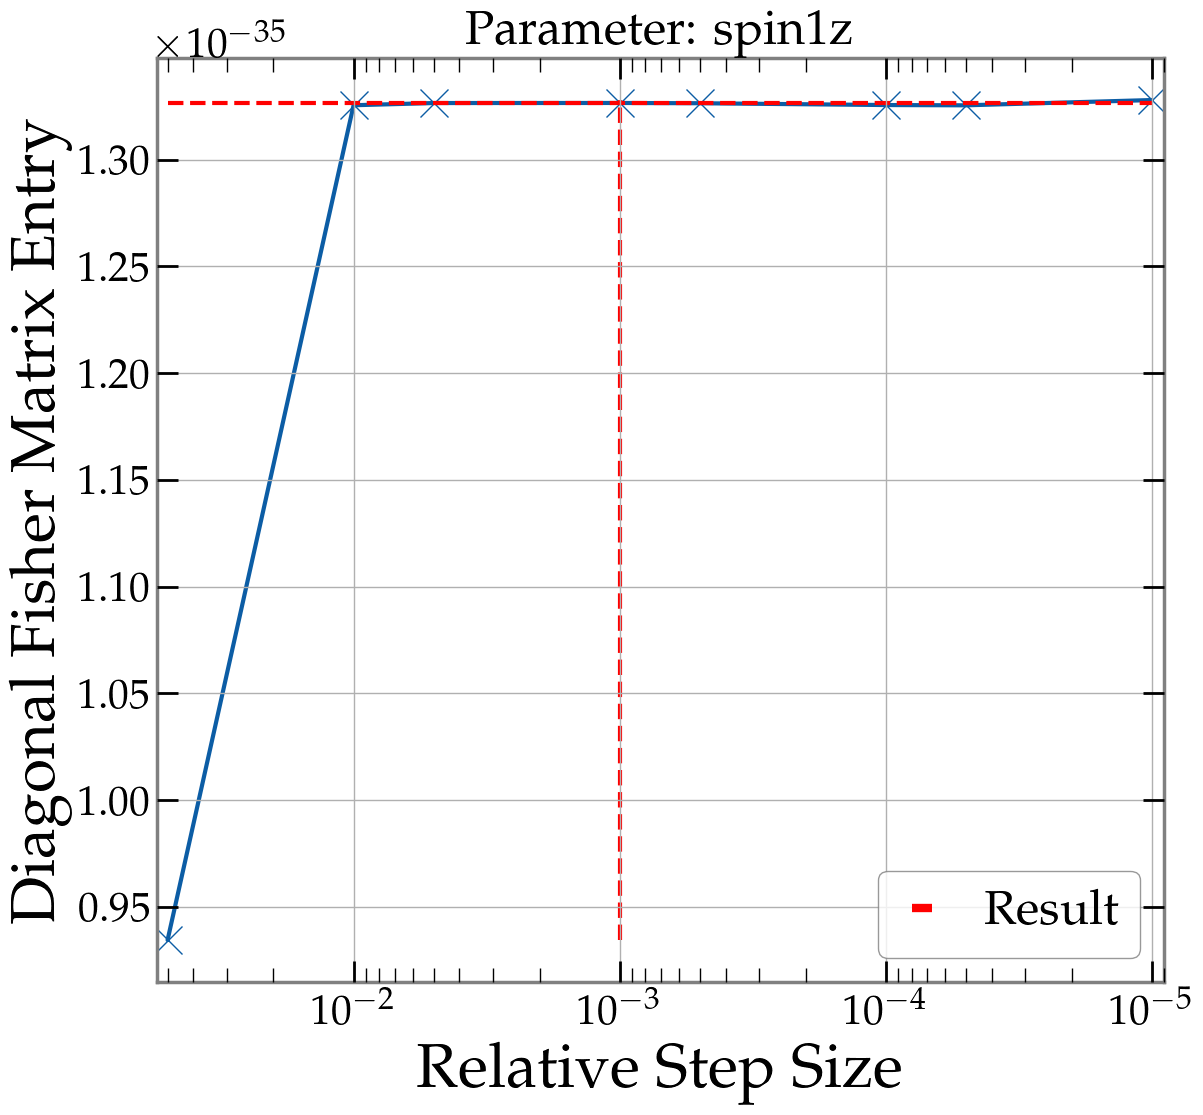

In [30]:
fisher_vals_spin1z = []

for check in ['rel_deviation', 'diff_norm', 'mismatch', 'stem']:
    fisher_test_val = fisher_val_v3(
        spin1z_check_params,
        'spin1z',
        gen,
        convergence_check=check,
        # convergence_threshold=0.0,
        convergence_plot=True
    )

    fisher_vals_spin1z += [fisher_test_val]

In [31]:
print(fisher_vals_spin1z)

[[[<Quantity 1.32652198e-35 1 / s2>]], [[<Quantity 1.32652198e-35 1 / s2>]], [[<Quantity 1.32652198e-35 1 / s2>]], [[<Quantity 1.32652198e-35 1 / s2>]]]


XLAL Warning - XLALSimInspiralWaveformParamsLookupMass1 (LALSimInspiralWaveformParams.c:490): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMassRatio (LALSimInspiralWaveformParams.c:851): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMass2 (LALSimInspiralWaveformParams.c:669): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is

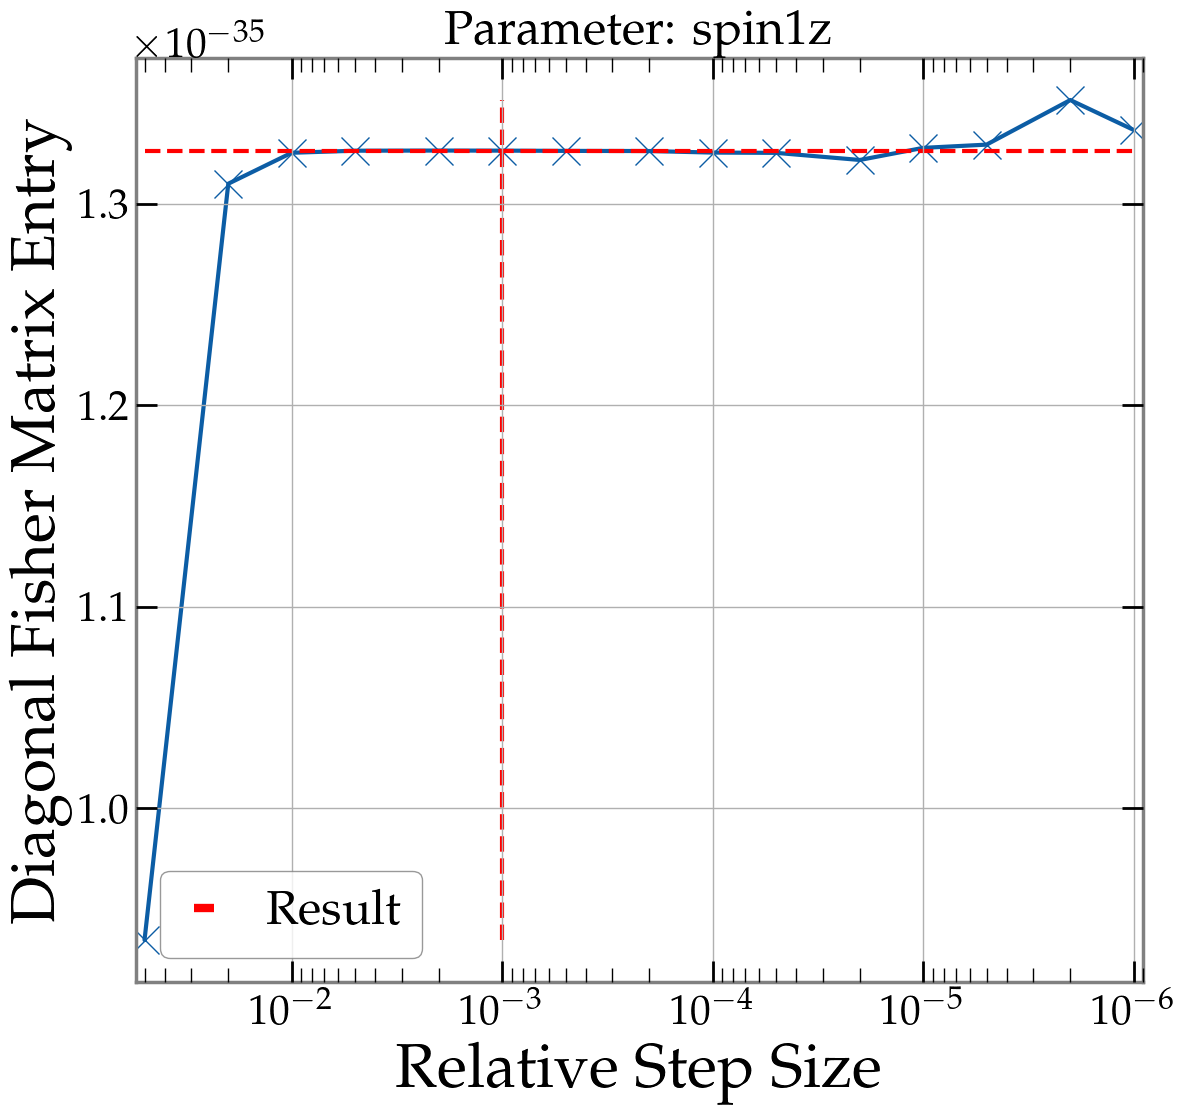

In [32]:
fisher_test_val = fisher_val_v3(
    spin1z_check_params,
    'spin1z',
    gen,
    step_sizes=conv_check_step_sizes,
    convergence_check='stem',
    break_upon_convergence=False,
    convergence_plot=True
)

## Numdifftools

In [33]:
import numdifftools as nd

In [34]:
hp_f_center, _ = wfm.GenerateFDWaveform(wf_center_parameters, gen)

/home/user/miniconda3/envs/gw_signal_tools/lib/python3.11/site-packages/lalsimulation/gwsignal/core/utils.py:277: UserWarning: The larger object cannot be determined, assuming m1 >= m2.
  warnings.warn(warn_string)
XLAL Warning - XLALSimInspiralWaveformParamsLookupMass1 (LALSimInspiralWaveformParams.c:490): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupSymMassRatio (LALSimInspiralWaveformParams.c:869): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralGetMassRatioFromSymMassRatio (LALSimInspiralWaveformParams.c:427): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWavefo

In [35]:
param_to_vary = 'total_mass'
wf_generator = gen

def deriv_wrapper(param_val):
    # return wfm.GenerateFDWaveform(wf_center_parameters | {param_to_vary: param_val*wf_center_parameters[param_to_vary].unit}, wf_generator)[0]
    return np.real(wfm.GenerateFDWaveform(wf_center_parameters | {param_to_vary: param_val*wf_center_parameters[param_to_vary].unit}, wf_generator)[0])

Need real part here because nd.Derivative only wants real numbers... Sooo, could we circumvent this by using that we want to differentiate with respect to a real variable, which means the derivative of $a + i \cdot b$ is just $\frac{d a}{dx} + i \cdot \frac{d b}{dx}$? Should be true, right?

In [36]:
nd_deriv = nd.Derivative(deriv_wrapper, full_output=True)  # To also get error estimate
# nd_deriv = nd.Derivative(deriv_wrapper, full_output=True, method='complex')  # Only throws errors -> ahh, because complex numbers are given to waveform generator I think

In [37]:
total_mass_nd_deriv = nd_deriv(100)

XLAL Warning - XLALSimInspiralWaveformParamsLookupMass1 (LALSimInspiralWaveformParams.c:490): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupSymMassRatio (LALSimInspiralWaveformParams.c:869): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralGetMassRatioFromSymMassRatio (LALSimInspiralWaveformParams.c:427): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMass2 (LALSimInspiralWaveformParams.c:669): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code 

Shit, error comes from numpy: see https://github.com/pbrod/numdifftools/issues/72

-> ah, but it is thrown for good reason, [percentile function](https://github.com/numpy/numpy/blob/3bf3aad16813d2d4bd3d5cad9f1380b882f20dc4/numpy/lib/_function_base_impl.py#L4262) that is used is not applicable to complex numbers because they are unordered set (as explained [here](https://github.com/numpy/numpy/issues/22652))! So the error does make sense! It's a shame that numdifftools does not seem to be maintained, though, so this won't be fixed as it seems...

In [38]:
print(type(total_mass_nd_deriv))

<class 'tuple'>


/home/user/miniconda3/envs/gw_signal_tools/lib/python3.11/site-packages/lalsimulation/gwsignal/core/utils.py:277: UserWarning: The larger object cannot be determined, assuming m1 >= m2.
  warnings.warn(warn_string)
XLAL Warning - XLALSimInspiralWaveformParamsLookupMass1 (LALSimInspiralWaveformParams.c:490): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupSymMassRatio (LALSimInspiralWaveformParams.c:869): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralGetMassRatioFromSymMassRatio (LALSimInspiralWaveformParams.c:427): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWavefo

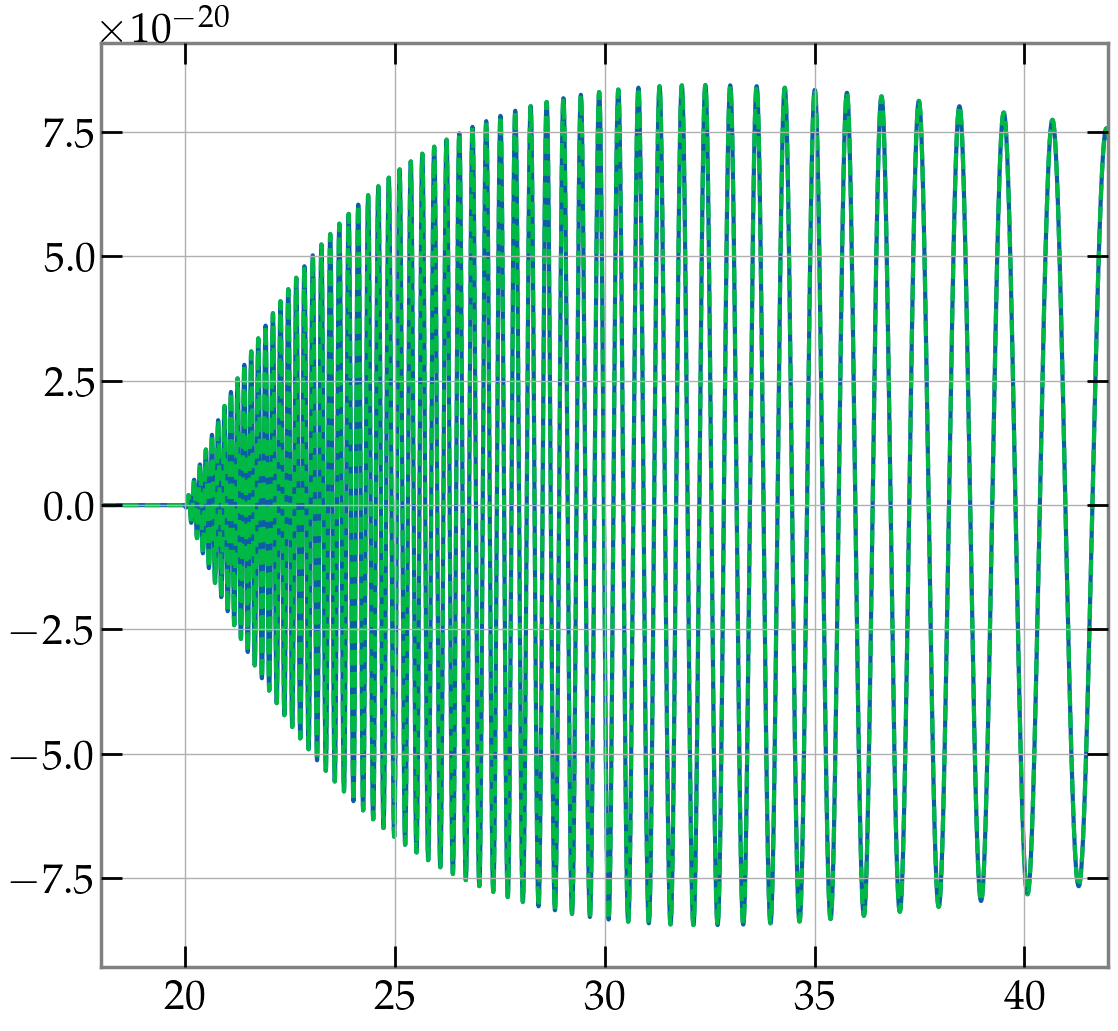

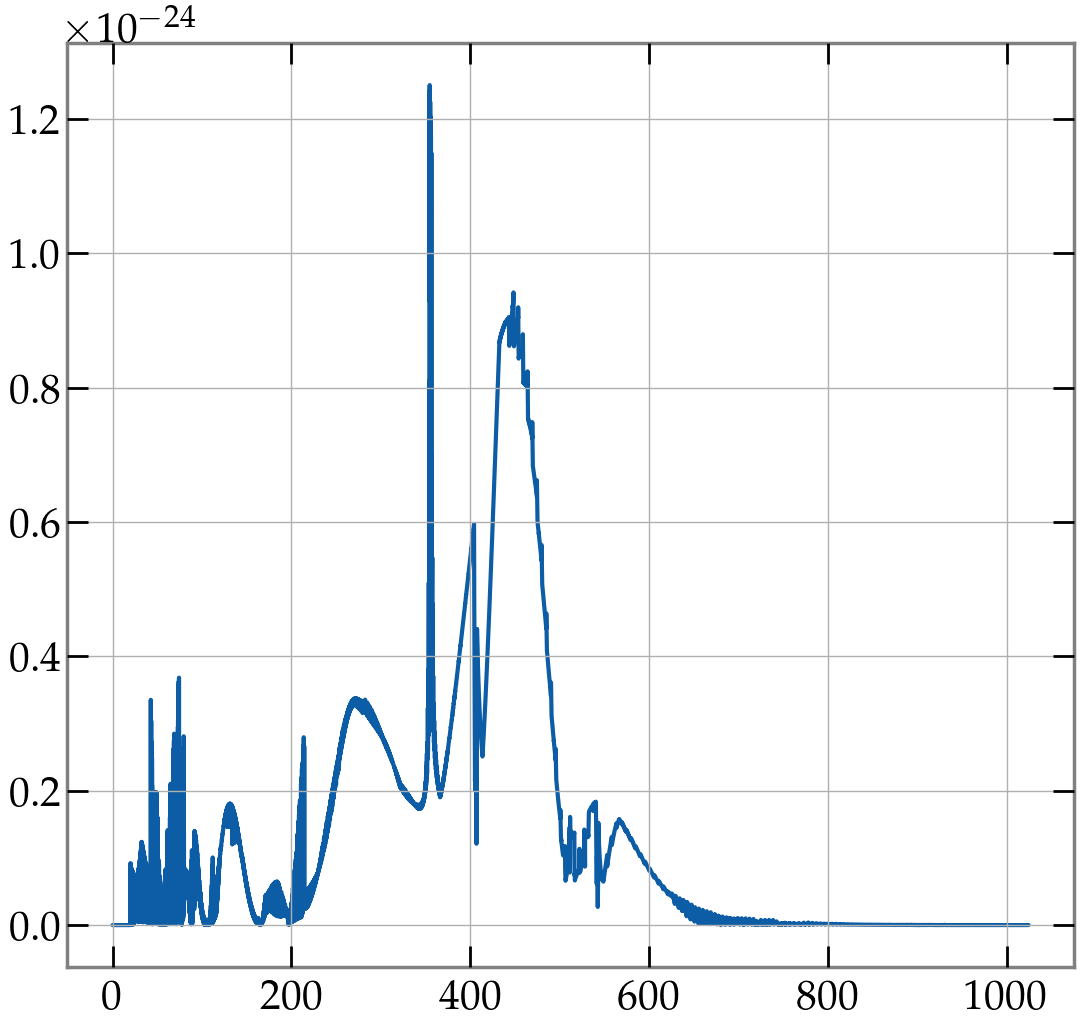

XLAL Warning - XLALSimInspiralWaveformParamsLookupMass1 (LALSimInspiralWaveformParams.c:490): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupSymMassRatio (LALSimInspiralWaveformParams.c:869): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralGetMassRatioFromSymMassRatio (LALSimInspiralWaveformParams.c:427): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMass2 (LALSimInspiralWaveformParams.c:669): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code 

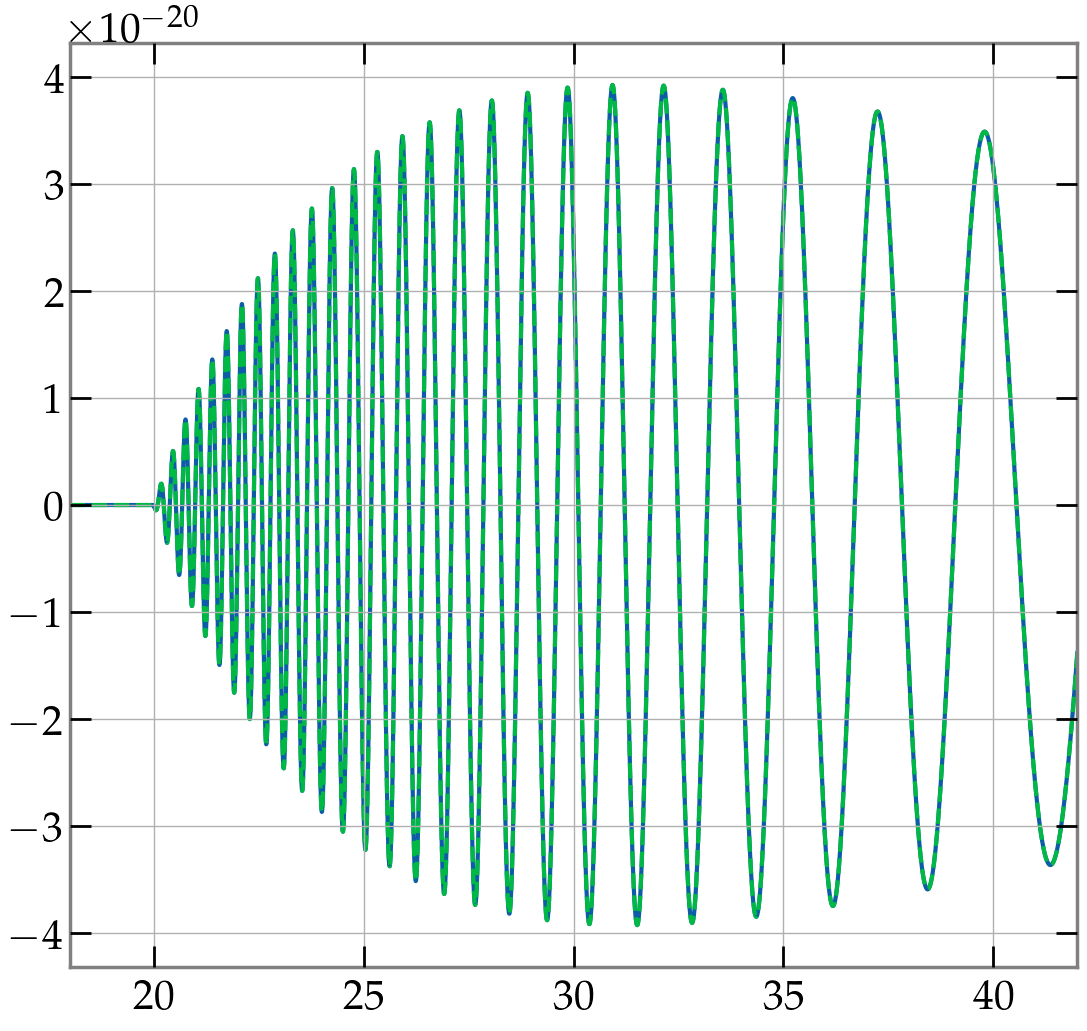

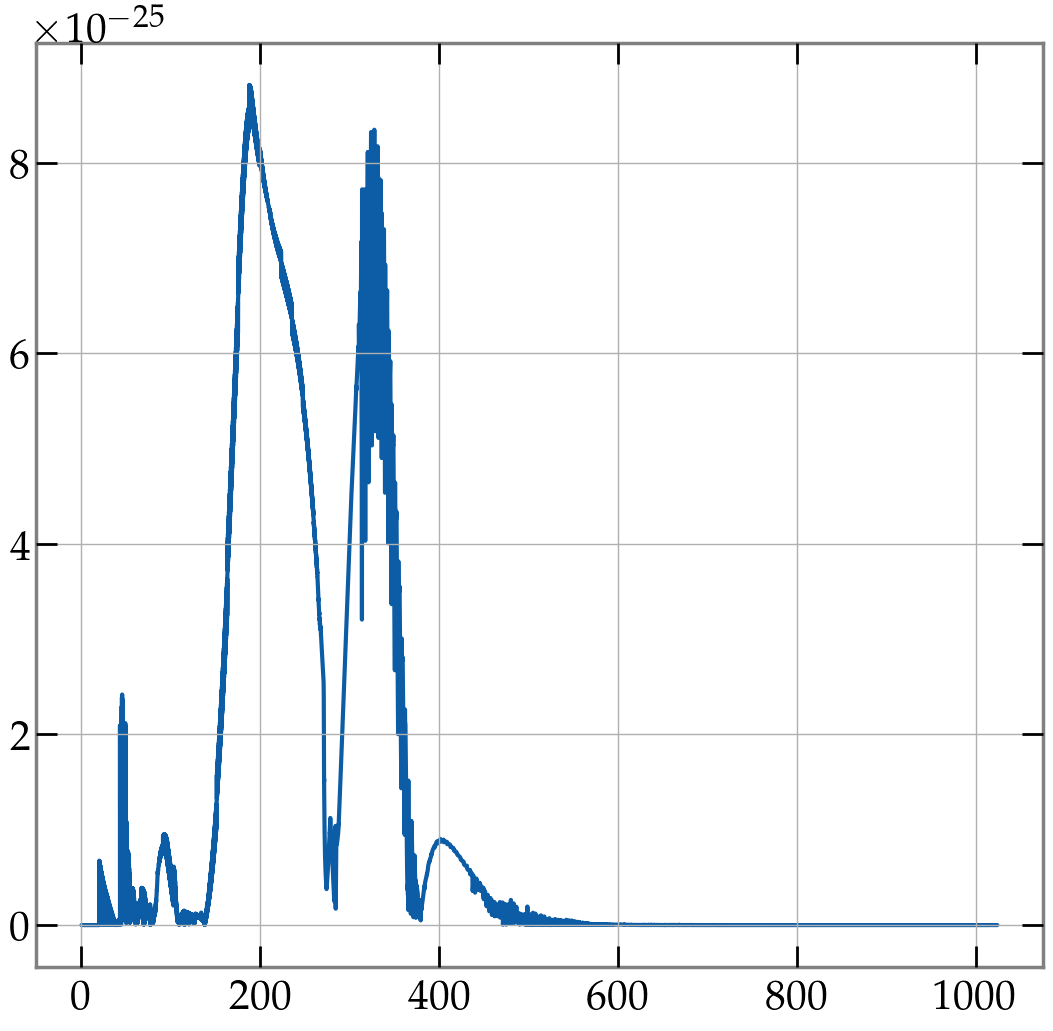

XLAL Warning - XLALSimInspiralWaveformParamsLookupMass1 (LALSimInspiralWaveformParams.c:490): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupSymMassRatio (LALSimInspiralWaveformParams.c:869): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralGetMassRatioFromSymMassRatio (LALSimInspiralWaveformParams.c:427): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMass2 (LALSimInspiralWaveformParams.c:669): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code 

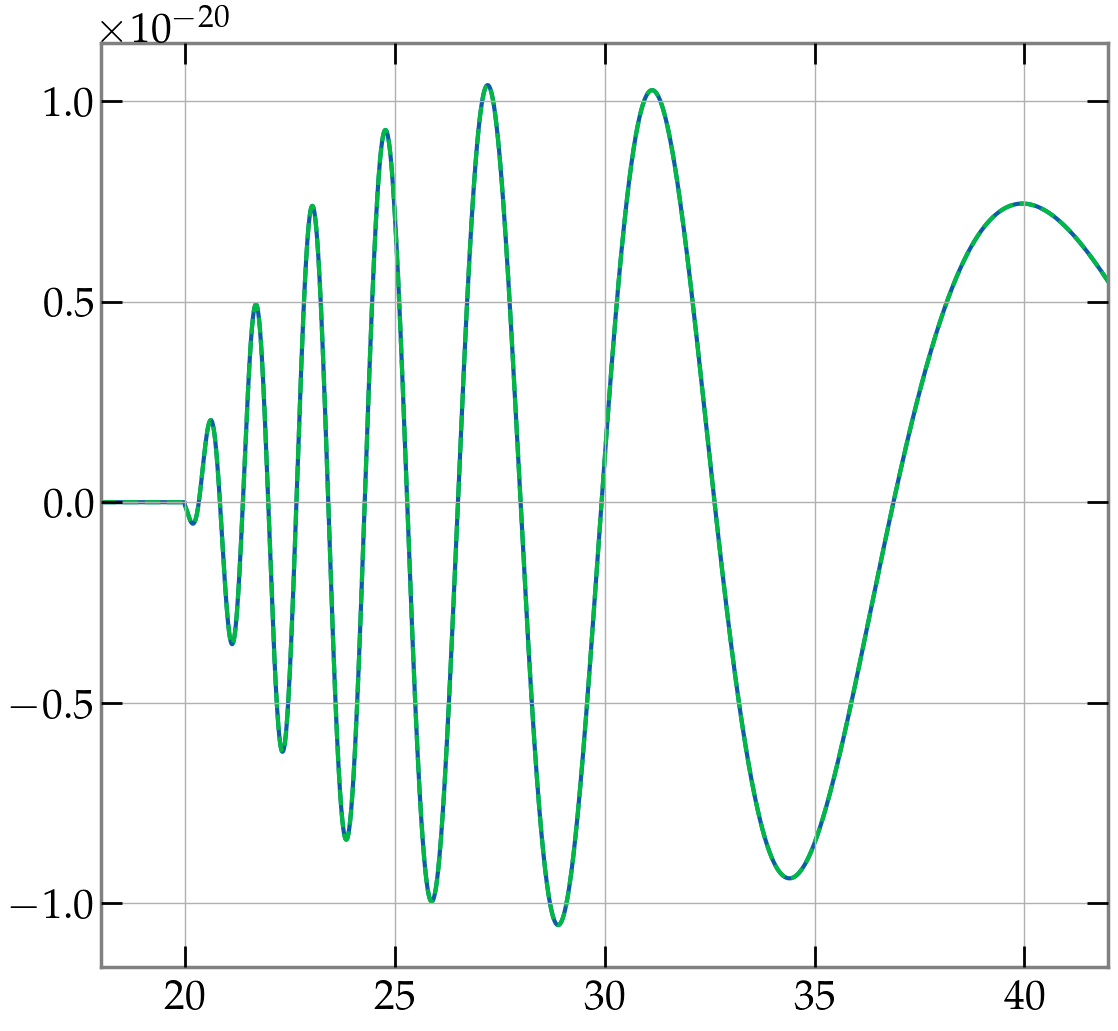

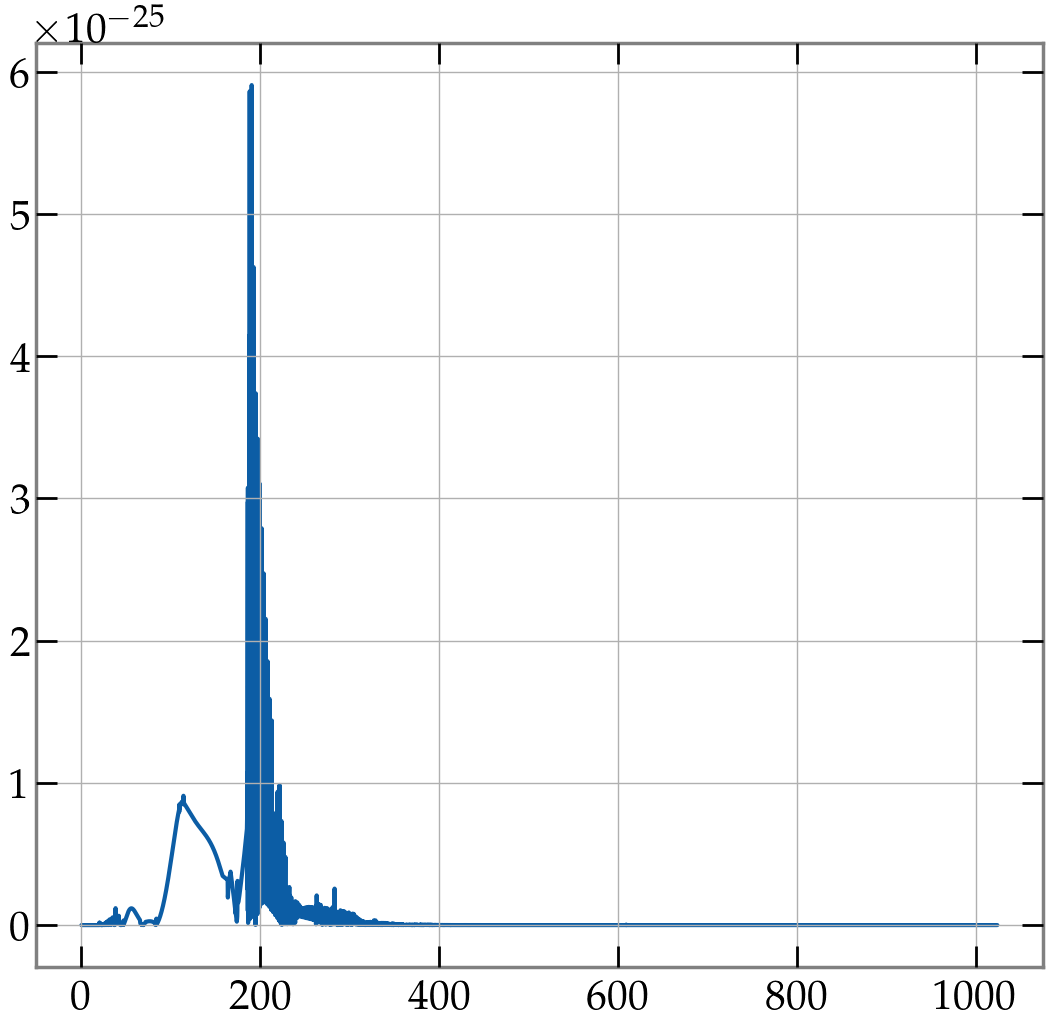

In [39]:
for mass in [42, 60, 100]:
    total_mass_nd_deriv = nd_deriv(mass)

    total_mass_num_deriv = get_waveform_derivative_1D(wf_center_parameters | {'total_mass': mass*u.solMass}, 'total_mass', gen, 0.0005)


    plt.plot(total_mass_num_deriv.frequencies, total_mass_nd_deriv[0])
    plt.plot(total_mass_num_deriv, '--')

    # plt.plot(total_mass_num_deriv.frequencies, np.abs(total_mass_nd_deriv[0]))
    # plt.plot(np.abs(total_mass_num_deriv), '--')


    plt.xlim([18, 42])

    plt.show()


    plt.plot(total_mass_num_deriv.frequencies, total_mass_nd_deriv[1].error_estimate)
    

    # plt.xlim([18, 42])

    plt.show()

In [40]:
def deriv_wrapper_real(param_val):
    return np.real(wfm.GenerateFDWaveform(wf_center_parameters | {param_to_vary: param_val*wf_center_parameters[param_to_vary].unit}, wf_generator)[0])

def deriv_wrapper_imag(param_val):
    return np.imag(wfm.GenerateFDWaveform(wf_center_parameters | {param_to_vary: param_val*wf_center_parameters[param_to_vary].unit}, wf_generator)[0])


nd_deriv_real = nd.Derivative(deriv_wrapper_real, full_output=False)

nd_deriv_imag = nd.Derivative(deriv_wrapper_imag, full_output=False)
# False more convenient here, for recombination (and also, should be fine, given situation above)

XLAL Warning - XLALSimInspiralWaveformParamsLookupMass1 (LALSimInspiralWaveformParams.c:490): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupSymMassRatio (LALSimInspiralWaveformParams.c:869): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralGetMassRatioFromSymMassRatio (LALSimInspiralWaveformParams.c:427): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMass2 (LALSimInspiralWaveformParams.c:669): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code 

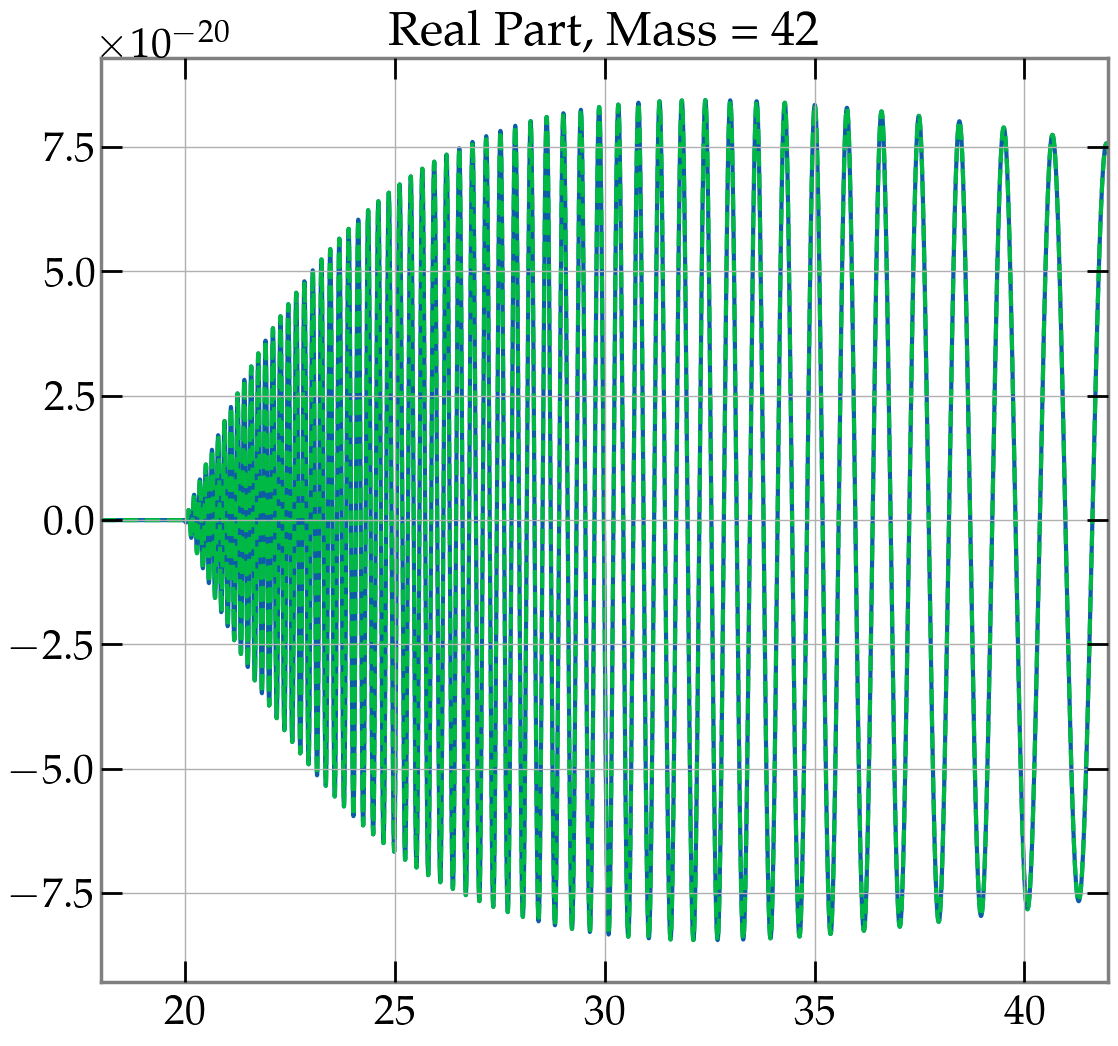

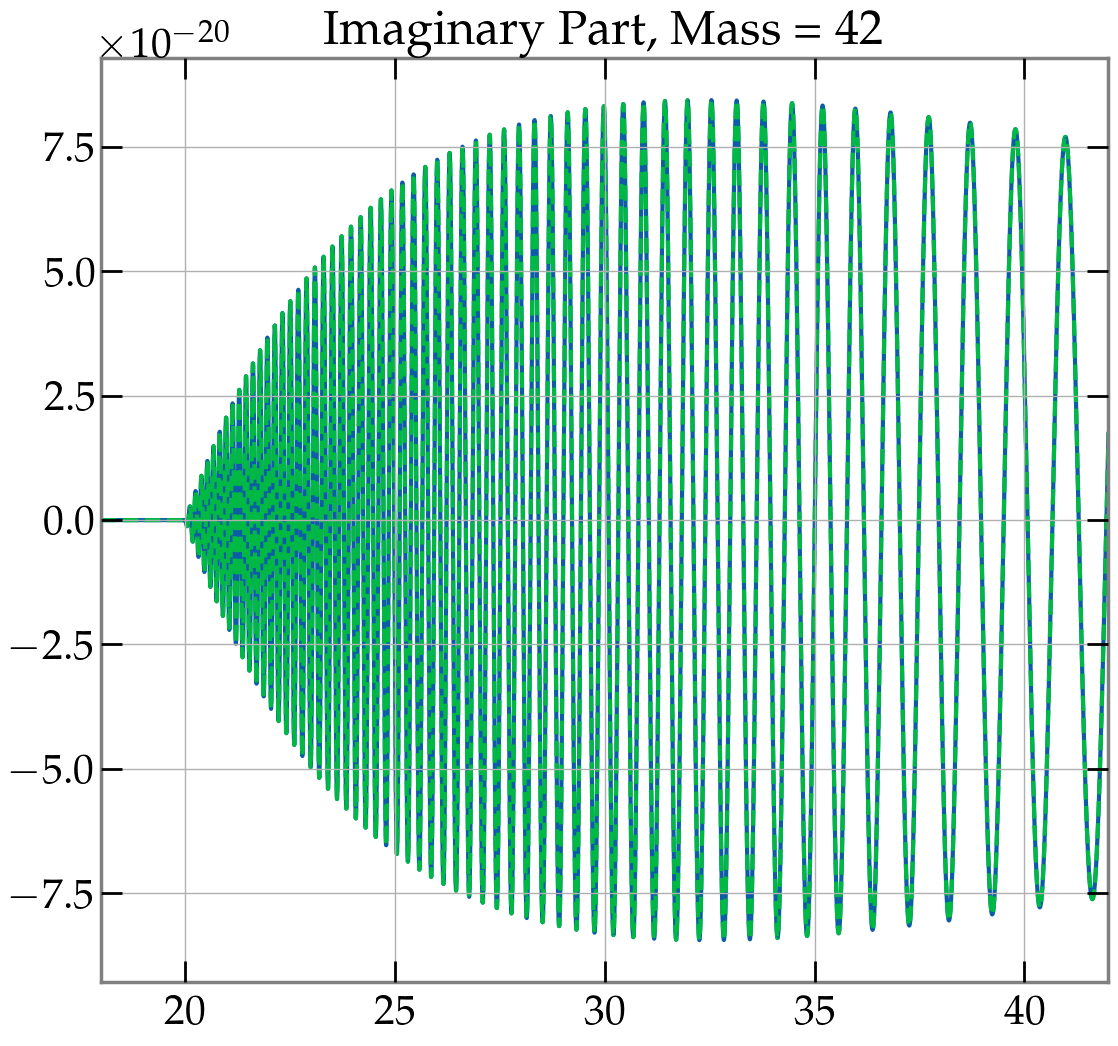

XLAL Warning - XLALSimInspiralWaveformParamsLookupMass1 (LALSimInspiralWaveformParams.c:490): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupSymMassRatio (LALSimInspiralWaveformParams.c:869): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralGetMassRatioFromSymMassRatio (LALSimInspiralWaveformParams.c:427): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMass2 (LALSimInspiralWaveformParams.c:669): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code 

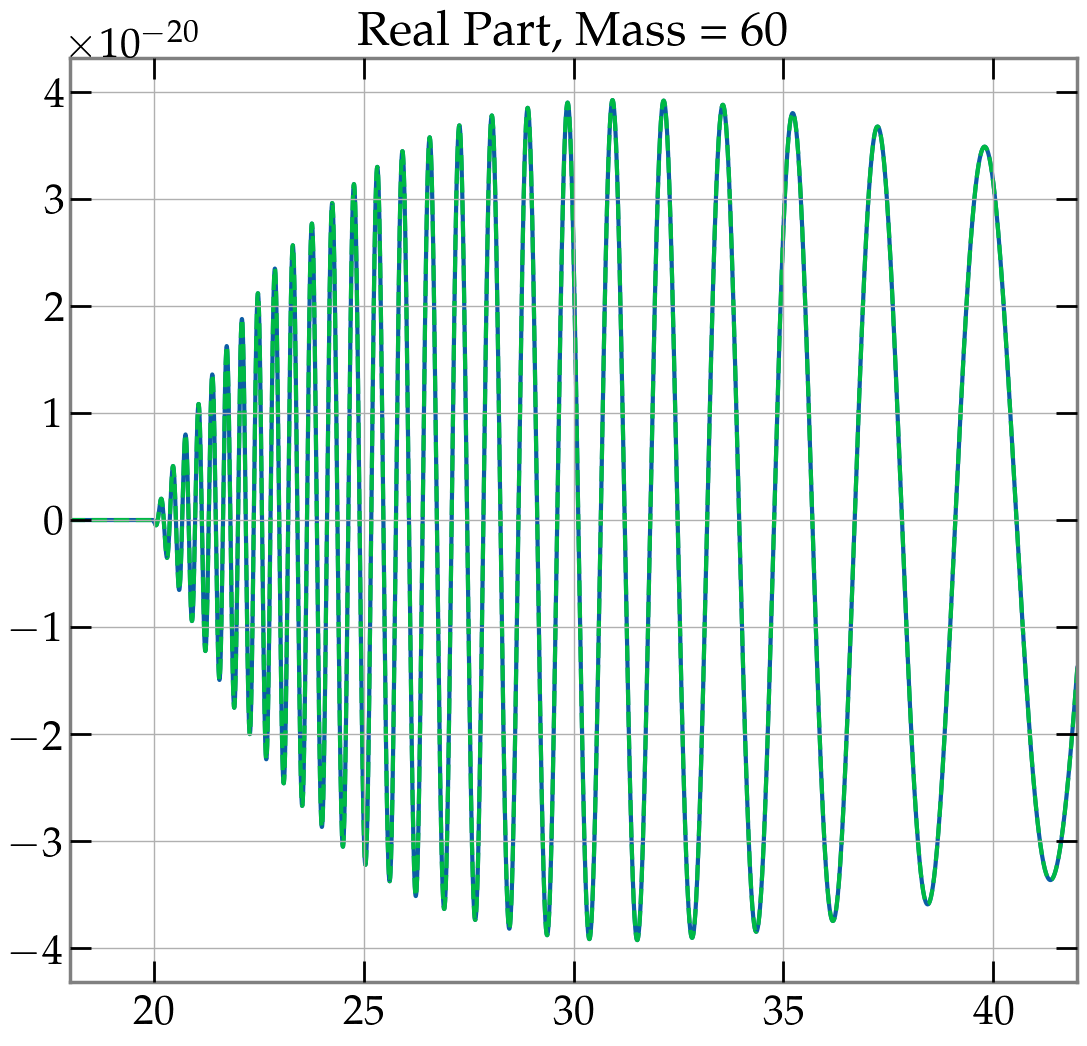

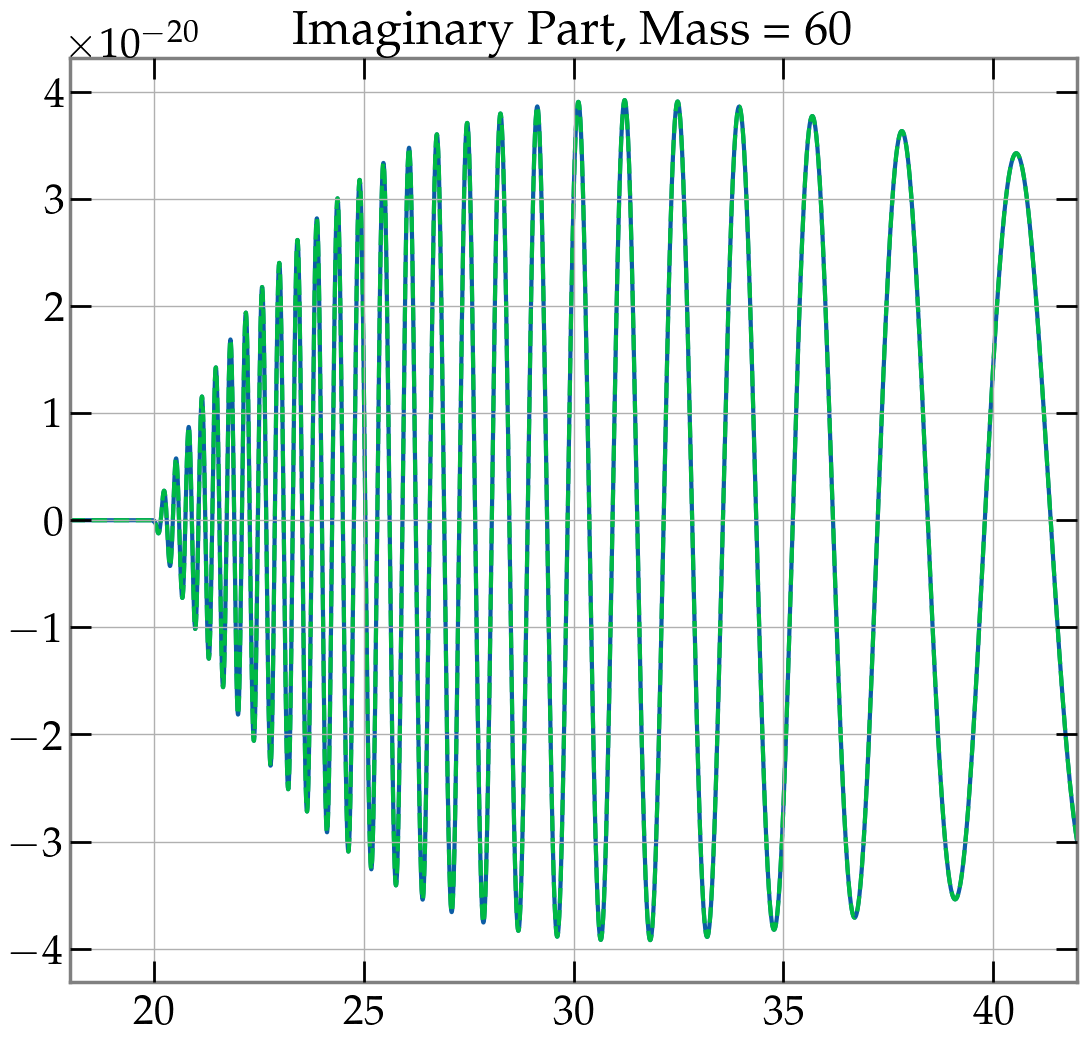

XLAL Warning - XLALSimInspiralWaveformParamsLookupMass1 (LALSimInspiralWaveformParams.c:490): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupSymMassRatio (LALSimInspiralWaveformParams.c:869): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralGetMassRatioFromSymMassRatio (LALSimInspiralWaveformParams.c:427): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMass2 (LALSimInspiralWaveformParams.c:669): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code 

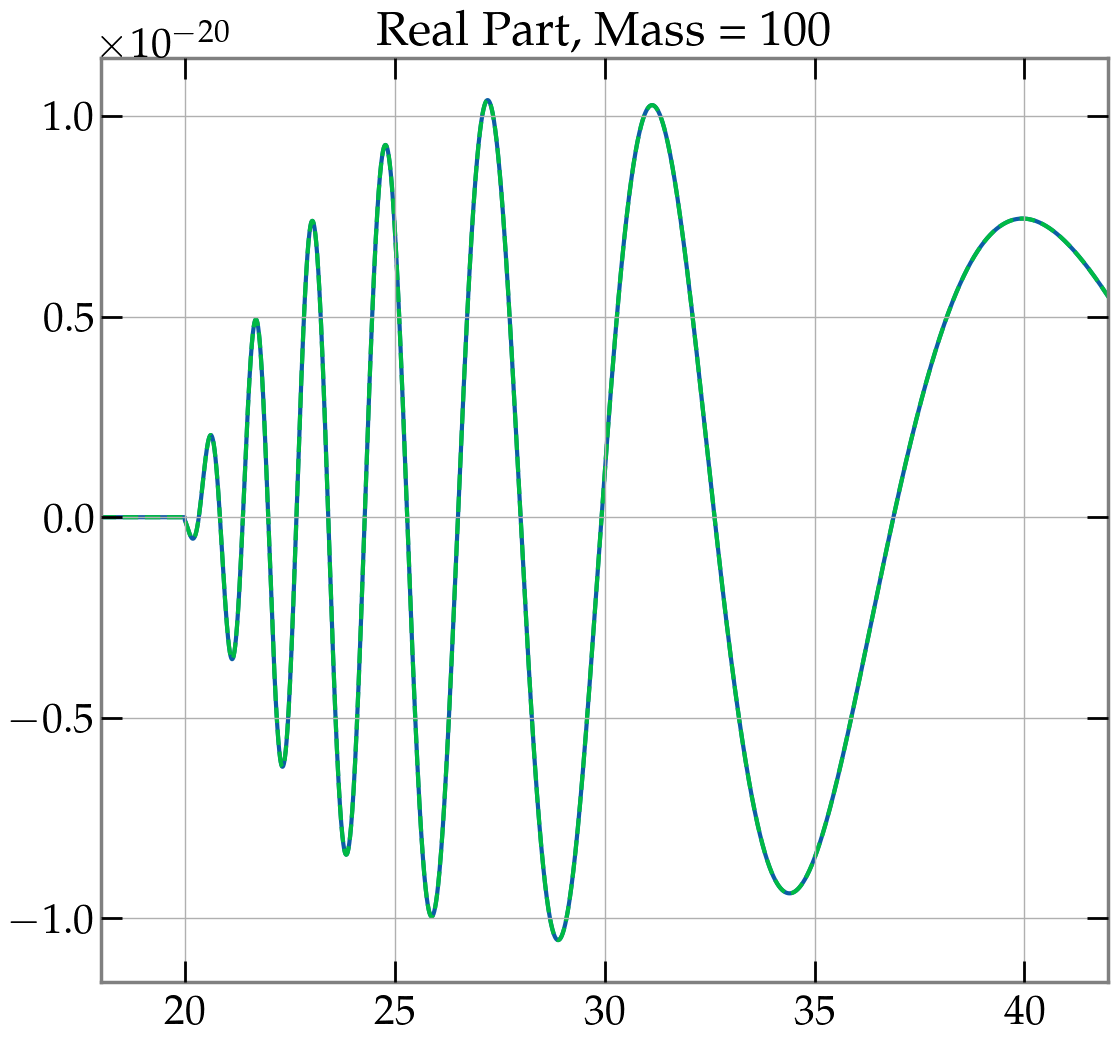

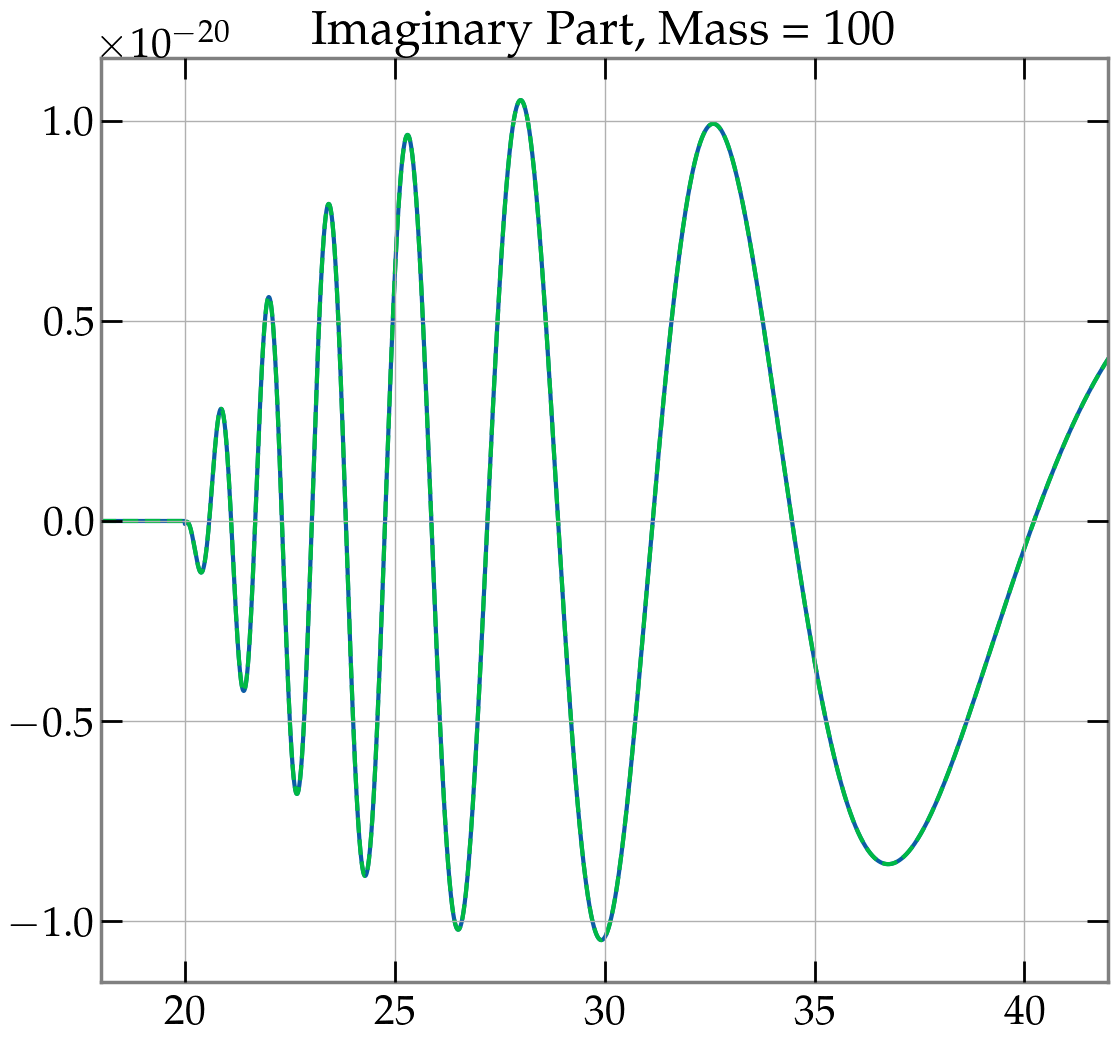

In [41]:
for mass in [42, 60, 100]:
    total_mass_nd_deriv = nd_deriv_real(mass) + 1.j * nd_deriv_imag(mass)

    total_mass_num_deriv = get_waveform_derivative_1D(wf_center_parameters | {'total_mass': mass*u.solMass}, 'total_mass', gen, 0.0005)


    plt.plot(total_mass_num_deriv.frequencies, np.real(total_mass_nd_deriv))
    plt.plot(total_mass_num_deriv, '--')


    plt.xlim([18, 42])

    plt.title(f'Real Part, Mass = {mass}')

    plt.show()


    plt.plot(total_mass_num_deriv.frequencies, np.imag(total_mass_nd_deriv))
    plt.plot(np.imag(total_mass_num_deriv), '--')


    plt.xlim([18, 42])

    plt.title(f'Imaginary Part, Mass = {mass}')

    plt.show()

Pretty annoying that it doesn't handle complex numbers... Doubles our computation time...